# Candidate number: 1047951
# Table of Contents.

# 1. Data Cleaning & Analysis
## 1.1. Missing Values - Replacement
## 1.2. Missing Values - Visualization
### 1.2.1. Plotting heatmap of NULL values
### 1.2.2. Plotting barchart
### 1.2.3. Plotting boxplot of respondents
### 1.2.4. Plotting boxplot of waves
### 1.2.5. Combining the plots
## 1.3. Dropping missing values and no variation
## 1.4. Transforming non-numerical columns
## 1.5. Getting different functional forms
# 2. Lasso - Continuous variables
## 2.1. Splitting the data and tuning alpha
## 2.2. Visualizing test errors
## 2.3. Building a function to get the data for predictions
## 2.4. Lasso prediction on leaderboard data
## 2.5. Lasso - quantile transform
### 2.5.1. Plotting outcome variables
### 2.5.2. Visualizing GPA transformation
### 2.5.3. Calculatting Lasso Quantile R^2
### 2.5.4. Testing Quantile model on leaderboard data
# 3. LightGBM
## 3.1. Setup and initialization of random search
## 3.2. Fitting categorical variables lightGBM
## 3.3. Predicting continuous variables
## 3.4. Evaluating LightGBM performance
## 3.5. Visualizing the results of random grid search
### 3.5.1. Importing data
### 3.5.2. Plotting MSE
# 4. Fitting Lasso residuals with LightGBM
## 4.1. Fitting the model
## 4.2. Plotting the residuals
## 4.3. Getting the data for residual fits
## 4.4. Fitting residuals on the leaderboard data
## 4.5. Calculating t-test statistic for whether there is any relationship between the predicted and actual results
## 4.6. Plotting residual predictions for each group
# 5. Running LightGBM, RF, and RF + MI
## 5.1. Setup
## 5.2. Plotting the brier loss
## 5.3. Evaluating the model on the leaderboard
## 5.4. Random forest prediction (legacy)
## 5.5. Plotting the historical RF data (legacy)
## 5.6. Classification with grid search
## 5.7. Mutual information regression
## 5.8. Visualizing Random Forest without Mutual Information
## 5.9. Visualizing random forest with mutual information
# 6. Classification - Ensemble model (by vote)
# 7. Shapley values
# 8. Do high leverage points impact bad predicions?
## 8.1. Fitting the model
## 8.2. Visualizing GPA, predicted vs real
## 8.3. Calculating z-scores
## 8.4. Plotting
# 9. Other
## 9.1. Calculating the statistic that each variable comes from some distribution

# 1. Data Cleaning & Analysis

In [766]:
import os
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   
import seaborn as sns
import ast
from tqdm import tqdm
import collections

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
%matplotlib inline
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

## 1.1. Missing Values - Replacement

In [767]:
# Set directories
raw_data_dir = f'.{os.sep}FFChallenge_v5/'
clean_data_dir = f'.{os.sep}data/'

def replace_na(df):
    """Replace different values with NAs. Assume that all negative values
    are NAs. There are some minor subtleties"""

    # Get NAN numbers
    replace_nan = {x: np.nan for x in np.arange(-2, -10, -1)}
    replace_nan["Missing"] = np.nan

    # Replace NANs
    df = df.replace(replace_nan)

    return df

In [768]:
constant_vars = pd.read_csv('FFChallenge_v5/constantVariables.txt',header=None, index_col=0)

In [769]:
background = pd.read_csv(f'{raw_data_dir}/background.csv', low_memory=False)
targets = pd.read_csv(f"{raw_data_dir}/train.csv")
df = targets.merge(background, how="left", on="challengeID")

In [770]:
# Replace the NA values
background_v2 = background.copy() # Get a dataframe to maintain the original values (used for plotting distribution)
background = replace_na(background)

In [771]:
background.isnull().mean().mean()

0.7337035867224843

## 1.2. Missing Values - Visualization

### 1.2.1. Plotting heatmap of NULL values

In [772]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [497]:
def plot_null(ax, tosample=True, sample=50, labelsize=16):
    if tosample:
        sns.heatmap(background.isnull().sample(sample), cbar=False, ax=ax, cmap=cmap, alpha=0.7)
    else:
        sns.heatmap(background.isnull(), cbar=False, ax=ax, cmap=cmap, alpha=0.7)
    
    # Create a legend
    patch1 = mpatches.Patch(color=bcolor, alpha=0.7, label='Not missing data')
    patch2 = mpatches.Patch(color=rcolor, alpha=0.7, label='Missing data')
    ax.legend(handles=[patch1, patch2], frameon=False, fontsize=labelsize, bbox_to_anchor=(1,-0.2), loc = 'lower right')

    ax.set_xticks([])
    ax.set_xlabel("The features", fontsize=labelsize)
    ax.set_ylabel("The observations", fontsize=labelsize)
    ax.set_yticks([])
    ax.set_title("Heatmap of missing values in the dataframe", fontsize=labelsize)

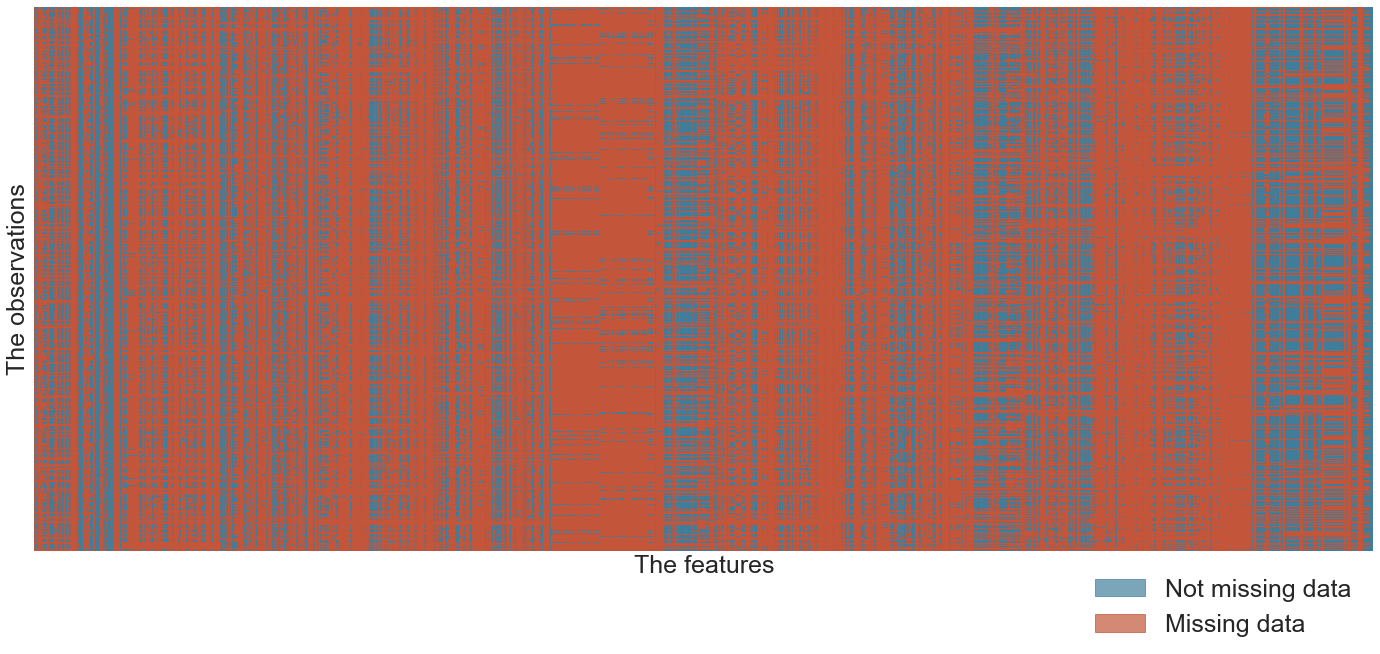

In [504]:
fig, ax = plt.subplots(1,1, figsize=(24,10))

plot_null(ax, tosample=False, labelsize=25)
ax.set_title("")
plt.plot()
fig.savefig('heatmap_missing2.png')

### 1.2.2. Plotting barchart

In [70]:
# Create a dictionary with all the mappings for NA values
replace_nan = {}
replace_nan = {x: x for x in np.arange(-1, -10, -1)}
replace_nan["Missing"] = 'Missing'
replace_nan[np.nan] = 'Nan'

In [71]:
# Map the dataframe to all values in a single column
all_vars = pd.melt(background_v2)
all_vars['value_full'] = all_vars['value'].map(replace_nan)
all_vars['value_full'] = all_vars['value_full'].fillna('Not Missing')

In [72]:
visualize_vals = all_vars.value_full.value_counts(dropna=False)

In [74]:
visualize_vals.index = ['Not Missing', '-6 (Skip)', '-9 (Not in wave)', '-3 (Missing)', '-7 (N/A)', 'Missing (NANs)', '-2 (Dont know)', '-5 (Not asked)', '-1 (Refused)', 'Missing (string)', '-8 (Out of range)', '-4 (Multiple answers)'] 

In [120]:
visualize_vals = visualize_vals.sort_values(ascending=True)

In [331]:
y = visualize_vals.index
x = visualize_vals.values

In [154]:
yticks = [str(round(v/1_000_000,2)) + 'M' if v >= 1000_000 else str(round(v/1_000,2)) + 'K' for v in x]

In [204]:
yticks = ['  ' + x for x in yticks]

In [122]:
y_pos = np.arange(len(y))

In [222]:
bcolor = '#43809D'
rcolor = '#C3573B'

In [223]:
colors = [rcolor for x in range(len(x) -1)] + [bcolor]

In [237]:
# Create a legend
patch1 = mpatches.Patch(color=bcolor, alpha=0.7, label='Not missing data')
patch2 = mpatches.Patch(color=rcolor, alpha=0.7, label='Missing data')


In [505]:
def plot_barchart(ax, labelsize=16):
    

    bar = ax.barh(y_pos, x, color=colors, align='center', alpha=0.7, linewidth=1, edgecolor='black')

    # Set width
    width=0.3

    # Set yticks
    ax.set(yticks=y_pos-width/2, yticklabels=y, ylim=[2* width - 1, len(y)])
    
    # Set labels
    for i,v in enumerate(x):
        ax.text(v+0.15, i-0.15, yticks[i], fontsize=12)

    # Set labels
    ax.set_xlabel("Number of values", fontsize=labelsize)

    # Remove spines
    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)

    # Create a legend
    patch1 = mpatches.Patch(color=bcolor, alpha=0.7, label='Not missing data')
    patch2 = mpatches.Patch(color=rcolor, alpha=0.7, label='Missing data')
    ax.legend(handles=[patch1, patch2], loc = 'lower right', frameon=False, fontsize=labelsize)
    
    # Set tick sizes
    
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(labelsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(labelsize)
        
    # Set title
    ax.set_title("Frequency of different types of missing values", fontsize=labelsize)

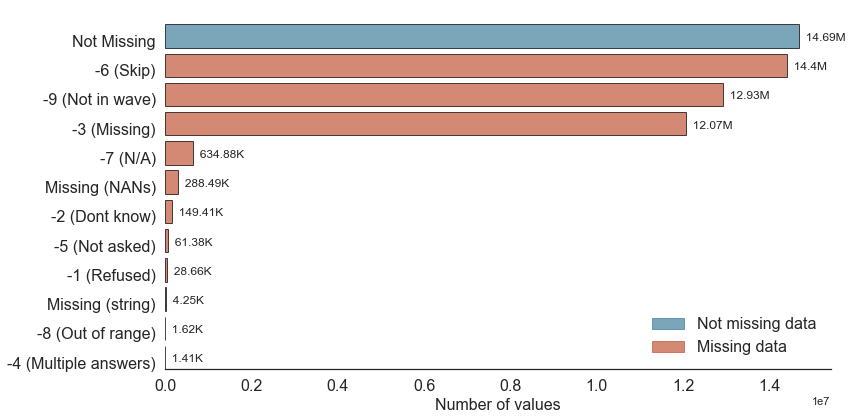

In [507]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

plot_barchart(ax)
ax.set_title("")
plt.tight_layout()
plt.show()
fig.savefig('missing_types.png')

### 1.2.3. Plotting boxplot of respondents

In [241]:
mdata = pd.read_json('variable_metadata.json')

In [244]:
mdata = mdata.transpose()

In [250]:
mdata.respondent.value_counts(dropna=False).sum()

10815

In [259]:
nuls = pd.DataFrame(background.isnull().mean())
nuls.columns = ['null_proportion']

In [263]:
mdata = mdata.merge(nuls, left_index=True, right_index=True)
boxdf = mdata[['respondent', 'wave', 'null_proportion']]

In [298]:
palette =  sns.diverging_palette(230, 20)

In [441]:
def plot_box_respondent(ax, labelsize=16):
        # Initial boxplot
    sns.boxplot(x='null_proportion', y='respondent', data=boxdf, width=0.7,
                ax=ax, orient='h', palette=palette, boxprops=dict(alpha=.8),
                saturation=.9)

    # Get stripplot
    sns.stripplot(x='null_proportion', y='respondent', data=boxdf, marker='o', size=2.5, alpha=0.5, ax=ax, palette=palette)

    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)
    
    ax.set_title("Null values based on respondent", fontsize=labelsize)
    ax.set_xlabel("Percent of feature null values", fontsize=labelsize)
    ax.set_ylabel("")
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(labelsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(labelsize) 

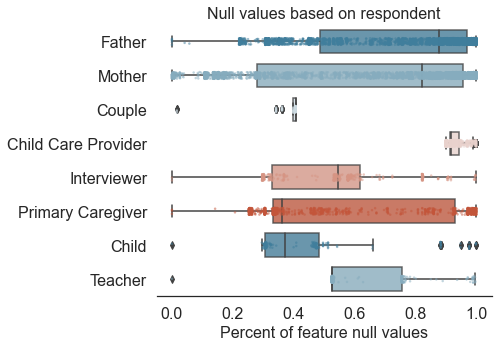

In [442]:
fig, ax = plt.subplots(1, figsize=(6,5))

plot_box_respondent(ax)

### 1.2.4. Plotting boxplots of waves

In [438]:
def plot_boxplot_wave(ax, labelsize=16):
    
        # Initial boxplot
    sns.boxplot(x='null_proportion', y='wave', data=boxdf, width=0.7,
                ax=ax, orient='h', palette=palette, boxprops=dict(alpha=.8),
                saturation=.9)

    # Get stripplot
    sns.stripplot(x='null_proportion', y='wave', data=boxdf, marker='o', size=2.5, alpha=0.5, ax=ax, palette=palette)
    
    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)

    ax.set_title("Null values based on wave", fontsize=labelsize)
    # Set labelsize
    ax.set_xlabel("Percent of feature null values", fontsize=labelsize)
    ax.set_ylabel("")
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(labelsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(labelsize) 

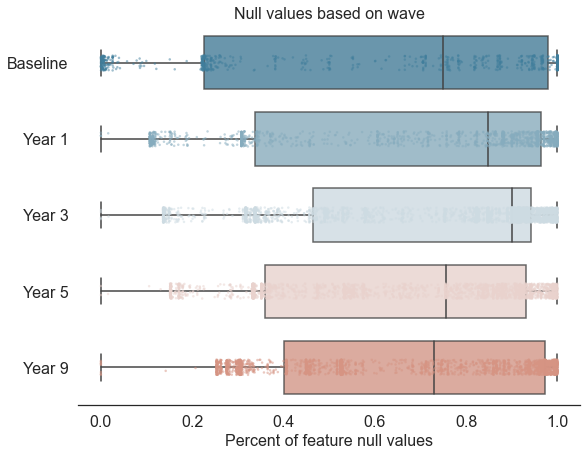

In [439]:
fig, ax = plt.subplots(1, figsize=(9,7))

plot_boxplot_wave(ax)

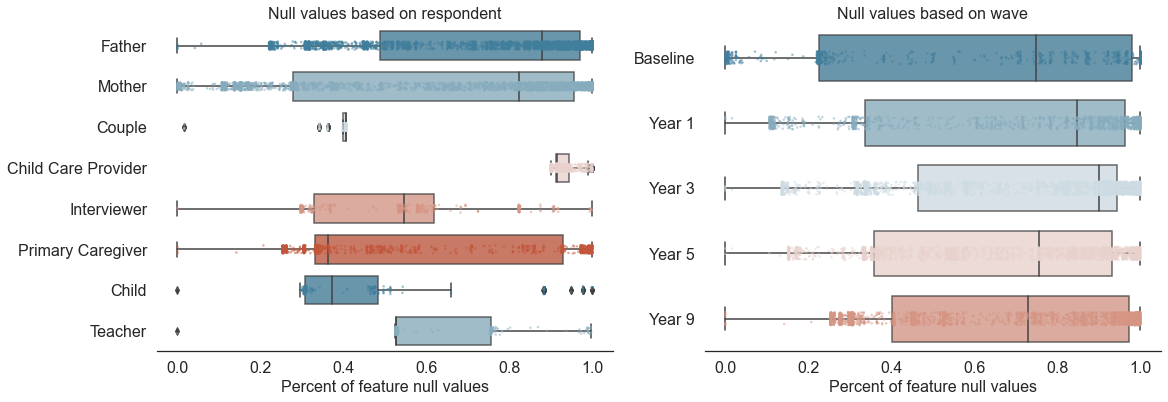

In [515]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

plot_box_respondent(ax[0])
plot_boxplot_wave(ax[1])

fig.savefig('null_boxplots.png')

### 1.2.5. Combining the plots

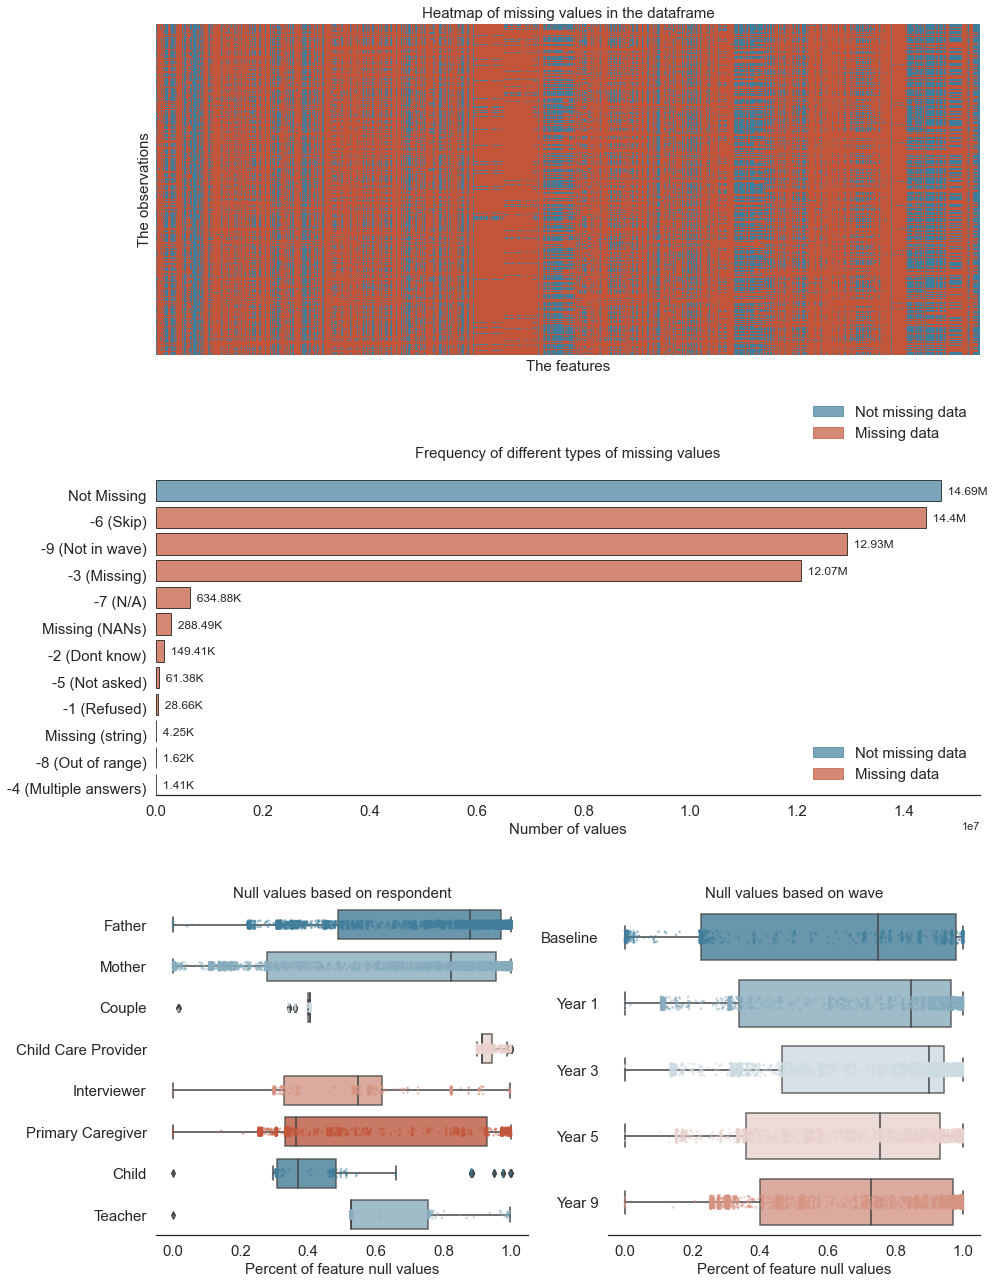

In [495]:
fig = plt.figure(figsize=(14,18))

gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])

# Set fontsize
labelsize=15
# Plot 1
plot_null(ax1, tosample=False, labelsize=labelsize)

# Plot 2
plot_barchart(ax2, labelsize=labelsize)

# Plot 3
plot_box_respondent(ax3, labelsize=labelsize)

# Plot 4
plot_boxplot_wave(ax4, labelsize=labelsize)

plt.tight_layout()
fig.savefig('null_values_graphic.png')

## 1.3. Dropping missing values and no variation

In [773]:
def drop_cols(df, threshold=0.8, const_vars=[]):
    """Drop columns with substantial number of NAs and those that do not vary"""

    print(f"Length before: {len(df.columns)}")
    # Drop features with higher mean NA than indicated
    df = df.loc[:, (df.isnull().mean() < threshold)]

    # Drop constant variables
    df = df.drop(const_vars, axis=1, errors="ignore")

    # Loop over other columns that do not substantially vary
    no_var = []
    for col in df.columns:
        if len(df[col].value_counts().index) == 1:
            no_var.append(col)
    
    df = df.drop(no_var, axis=1)
    print(f"Length after: {len(df.columns)}")
    return df


In [774]:
background = drop_cols(background, const_vars=constant_vars)

Length before: 13027
Length after: 5261


## 1.4. Transforming non-numerical columns

Look at the data types

In [775]:
mdata.data_type.value_counts()

Binary                   4819
Ordered Categorical      3024
Continuous               1854
Unordered Categorical     987
String                      9
Name: data_type, dtype: int64

In [776]:
# Get unordered categorical, binary, and string values
categ = [x for x in mdata[mdata.data_type.isin(['Unordered Categorical', 'Binary', 'String'])].index if x in background.columns]

# Get string (non-numerical) columns based on data types
categ_cols = list(background.dtypes[~background.dtypes.isin([np.float, np.int])].index)

# Combine the columns
ccols = list(np.unique(categ + categ_cols))

In [777]:
len(ccols)

2696

In [778]:
from tqdm import tqdm

In [779]:
def cut_unique_n(series, n=15):
    """Cut unique values to at least n times or transform to 'Other'"""
    series_ = series.value_counts()
    indices = series_[series_ >= n].index.tolist()
    other = [x for x in series_.index if x not in indices]
    
    replace_dict = {k:'Other' for k in other}

    return series.replace(replace_dict)

In [780]:
for c in tqdm(ccols):
    background[c] = cut_unique_n(background[c])

100%|██████████████████████████████████████████████████████████████████████████████| 2696/2696 [01:25<00:00, 31.53it/s]


In [781]:
for c in ccols:
    background[c] = background[c].astype(str)

In [782]:
len(ccols)

2696

In [783]:
conts = [x for x in background.columns if x not in ccols]

In [787]:
pd.get_dummies(background[ccols]).shape

(4242, 10969)

In [784]:
background_transformed = pd.concat([background[conts], pd.get_dummies(background[ccols])], axis=1)

In [786]:
print(f"Columns after: {len(background.columns)}")

Columns after: 5261


## 1.5. Getting different functional forms 

In [790]:
def col_names(start, float_cols):
    return [x + '_' + start for x in float_cols]

In [808]:
def get_functional_forms(df, float_cols=conts, targets=targets):
    float_cols = df.dtypes[(df.dtypes == 'float64') & (~df.columns.isin(targets.columns))].index

    df_sqrt = np.sqrt(df[float_cols])
    df_sqrt.columns = col_names('sqrt', float_cols)

    # Add epsilon to the log form
    df_log = np.log(df[float_cols] + np.finfo(np.float32).eps)
    df_log.columns = col_names('log', float_cols)

    df_square = np.power(df[float_cols], 2)
    df_square.columns = col_names('square', float_cols)
    
    df_all = pd.concat([df_sqrt, df_log, df_square, df], axis=1).copy()
    
    return df_all

In [809]:
df_all = get_functional_forms(background_transformed, conts, targets=targets)

In [810]:
df_all

,cf1lenhr_sqrt,cf1lenmin_sqrt,f1citywt_sqrt,f1a6a_sqrt,cf1age_sqrt,f1b1a_sqrt,f1b3_sqrt,f1b12a_sqrt,f1b12b_sqrt,f1b12c_sqrt,...,t5f5e_Other,t5f5e_nan,t5f5f_1.0,t5f5f_2.0,t5f5f_Other,t5f5f_nan,t5f5g_1.0,t5f5g_2.0,t5f5g_Other,t5f5g_nan
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,1
1,0.0,6.324555,8.273793,2.0,NaN,1.000000,1.000000,1.414214,1.000000,1.732051,...,0,0,0,1,0,0,1,0,0,0
2,0.0,6.708204,6.505310,NaN,4.898979,1.732051,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,1
3,0.0,6.708204,5.062492,NaN,4.898979,1.732051,1.000000,1.414214,1.732051,1.414214,...,0,1,0,0,0,1,0,0,0,1
4,NaN,7.071068,6.477228,NaN,4.358899,2.000000,1.000000,1.414214,1.414214,1.414214,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,1
4238,0.0,6.324555,8.012188,NaN,4.898979,0.000000,1.414214,1.732051,1.414214,1.732051,...,0,0,0,1,0,0,0,1,0,0
4239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,0,0,1
4240,1.0,0.000000,5.240371,1.0,5.385165,0.000000,1.732051,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,0,0


In [802]:
def drop_posttransform_na(df_all):
    nulls = df_all.isnull().mean()
    ind = nulls.index
    vals = nulls.values
    large_na = []
    for i, v in zip(ind, vals):
        if v > 0.8: large_na.append(i)
            
    df_all = df_all.drop(large_na, axis=1)
    return df_all

In [803]:
df_all = drop_posttransform_na(df_all)

In [804]:
df_all.shape

(4242, 21206)

In [828]:
df_all.to_csv('./data/transformed_data_all.csv', index=False)

In [829]:
background_transformed.to_csv('./data/transformed_data_nofuncform.csv', index=False)

In [816]:
df3 = df_all[['cf1lenhr_sqrt', 't5f5g_Other']].copy()

In [814]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer()

In [821]:
df3['t5f5g_Other'].value_counts()

0    4236
1       6
Name: t5f5g_Other, dtype: int64

In [826]:
pd.DataFrame(qt.fit_transform(df3), columns = df3.columns)

,cf1lenhr_sqrt,t5f5g_Other
0,NaN,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,NaN,0.0
...,...,...
4237,NaN,0.0
4238,0.000000,0.0
4239,NaN,0.0
4240,0.927427,0.0


# 2. Lasso - Continuous variables

## 2.1. Splitting the data and tuning alpha

In [778]:
# Splitting the data
# The naming of trains (instead of train) is intentional for filtering our outcome variable indices
X_trains, X_cv, y_trains, y_cvs = train_test_split(df.loc[train.index], train, test_size=0.25, random_state=42)

# Filling in with means
means_train = X_trains.mean()
X_trains = X_trains.fillna(means_train)
X_cv = X_cv.fillna(means_train)

# Scaling variables for Lasso
scaler = StandardScaler()
X_trains_scaled = pd.DataFrame(scaler.fit_transform(X_trains), columns=X_trains.columns)
X_cv_scaled = pd.DataFrame(scaler.transform(X_cv), columns=X_cv.columns)

# Change indices
X_trains_scaled.index = X_trains.index
X_cv_scaled.index = X_cv.index

In [12]:
grit_min = train.grit.min()
grit_max = train.grit.max()

gpa_min = train.gpa.min()
gpa_max = train.gpa.max()

mh_min = train.materialHardship.min()
mh_max = 1 # Max from the test set is 0.81. Leaving it to one.

# Set the min-max values
min_max_values = {
          'gpa':  {'max': gpa_max,
                   'min': gpa_min},
          'grit': {'max': grit_max,
                   'min': grit_min},
          'materialHardship':   {'max': mh_max,
                   'min': mh_min}}

In [288]:
test_errors = {}
test_rsquared = {}

for outcome in ['gpa', 'grit', 'materialHardship']:
    print(f"Variable: {outcome}")

    # Let's drop instances where the response is NA
    y_train = y_trains[outcome].dropna()
    X_train_scaled = X_trains_scaled.loc[y_train.index.values]
    
    # Scale the y variable
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    
    # Create list for test errors
    test_errors[outcome] = []
    test_rsquared[outcome] = []

    # Create alphas
    alphas = np.logspace(-3,3,200)

    for i, a in enumerate(alphas):
        
        if i % 30 == 0:
            print(f"Alpha iteration {i}")

        # Fit the model
        model = Lasso(alpha=a, max_iter=100_000)
        model.fit(X_train_scaled, y_train_trans)

        # Make the predictions
        y_pred_trans = model.predict(X_cv_scaled)
        y_pred = y_train_mean + y_train_std*y_pred_trans

        # Get the min or max value
        min_value = min_max_values[outcome]['min']
        max_value = min_max_values[outcome]['max']

        # Get the predictions
        y_pred = np.clip(y_pred,min_value,max_value)

        # Get the non-null predictions
        y_cv_true = [y for x, y in zip(y_pred, y_cvs[outcome]) if not math.isnan(y)]
        y_pred_true = [x for x, y in zip(y_pred, y_cvs[outcome]) if not math.isnan(y)]

        # Calculate the scores
        mse = mean_squared_error(y_cv_true, y_pred_true)
        r2 = r2_score(y_cv_true, y_pred_true)
        
        # Append the values
        test_errors[outcome].append(mse)
        test_rsquared[outcome].append(r2)
        

Variable: gpa
Alpha iteration 0
Alpha iteration 30
Alpha iteration 60
Alpha iteration 90
Alpha iteration 120
Alpha iteration 150
Alpha iteration 180
Variable: grit
Alpha iteration 0
Alpha iteration 30
Alpha iteration 60
Alpha iteration 90
Alpha iteration 120
Alpha iteration 150
Alpha iteration 180
Variable: materialHardship
Alpha iteration 0
Alpha iteration 30
Alpha iteration 60
Alpha iteration 90
Alpha iteration 120
Alpha iteration 150
Alpha iteration 180


In [289]:
with open('./data/test_errors.json', 'w') as f:
    json.dump(test_errors, f)
    
with open('./data/rsquared.json', 'w') as f:
    json.dump(test_rsquared , f)

## 2.2. Visualizing test errors

In [131]:
with open('./data/test_errors.json') as f:
    test_errs = json.loads(f.read())

In [132]:
with open('./data/rsquared.json', 'r') as f:
    test_rsquared = json.loads(f.read())

In [138]:
test_rsquared.keys()

dict_keys(['gpa', 'grit', 'materialHardship'])

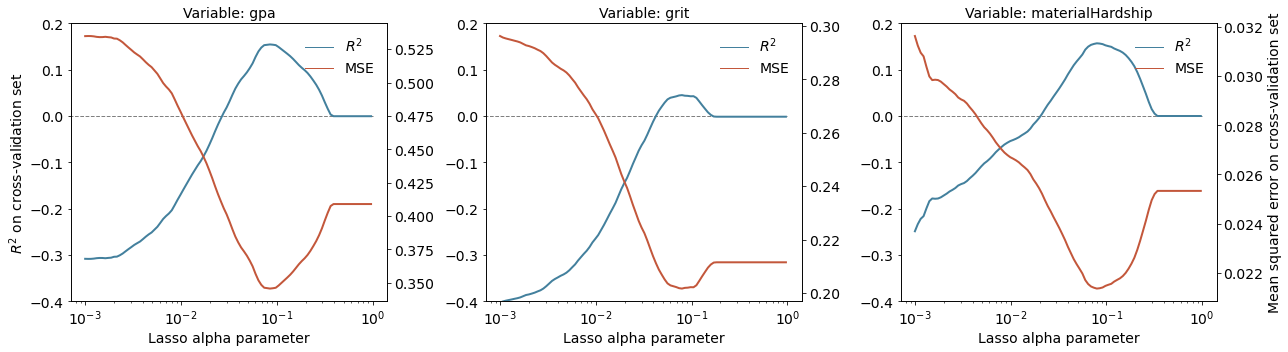

In [254]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

axs_ls = axs.flatten()

fontsize=14
for i, outcome in enumerate(['gpa', 'grit', 'materialHardship']):
    
    # Get axis
    ax = axs_ls[i]
    
    # Set max value for x-axis
    maxval = 100
    
    # Create x plots
    ax.plot(np.logspace(-3,3,200)[:maxval], pd.Series(test_rsquared[outcome][:maxval]), color = bcolor, linewidth=2)
    ax2 = ax.twinx()
    ax2.plot(np.logspace(-3,3,200)[:maxval], pd.Series(test_errs[outcome][:maxval]), color = rcolor, linewidth=2)

    # Make the horizontal label and set labels
    ax.hlines(0, 0, 1, linewidth=1, color='grey', linestyles='--')
    ax.set_xlabel("Lasso alpha parameter", fontsize=fontsize)
    ax.set_ylabel("$R^2$ on cross-validation set", fontsize=fontsize)
    ax2.set_ylabel("Mean squared error on cross-validation set", fontsize=fontsize)

    ax.set_ylim((-0.4, 0.2))
    ax.set_xscale('log')
    ax.legend(handles=custom_lines, loc='upper right', frameon=False, fontsize=fontsize)
    ax.set_title(f"Variable: {outcome}", fontsize=fontsize)
    
    if i in [1,2]: ax.set_ylabel("")
    if i in [0,1]: ax2.set_ylabel("")
        
    # Change the size of axes
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
    for tick in ax2.yaxis.get_major_ticks(): tick.label2.set_fontsize(fontsize)

plt.tight_layout()

fig.savefig('lasso_params.png')

In [171]:
bcolor = '#43809D'
rcolor = '#C3573B'

In [188]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [199]:
custom_lines = [Line2D([0], [0], color=bcolor, lw=1, label='$R^2$'),
                Line2D([0], [0], color=rcolor, lw=1, label='MSE')]

In [205]:
array = np.logspace(-3,3,200)

In [206]:
len(array)

200

Text(0.5, 1.0, 'Variable: gpa')

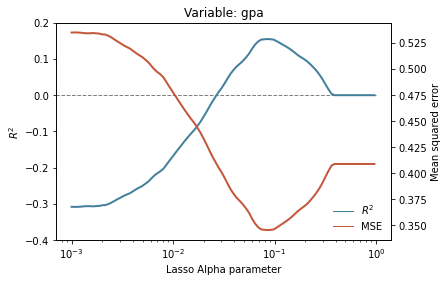

In [228]:
fig, ax = plt.subplots()

outcome = 'gpa'

maxval = 100
ax.plot(np.logspace(-3,3,200)[:maxval], pd.Series(test_rsquared[outcome][:maxval]), color = bcolor, linewidth=2)
ax2 = ax.twinx()

ax2.plot(np.logspace(-3,3,200)[:maxval], pd.Series(test_errs[outcome][:maxval]), color = rcolor, linewidth=2)

ax.hlines(0, 0, 1, linewidth=1, color='grey', linestyles='--')
ax.set_xlabel("Lasso Alpha parameter")
ax.set_ylabel("$R^2$")
ax2.set_ylabel("Mean squared error")

#ax.set_xlim((0,100
ax.set_ylim((-0.4, 0.2))
ax.set_xscale('log')
ax.legend(handles=custom_lines, loc='lower right', frameon=False)
ax.set_title(f"Variable: {outcome}")

In [133]:
min_mse = np.array(test_errs['gpa']).min()
min_alpha = [alpha for mse, alpha in zip(test_errs['gpa'], np.logspace(-3,3,200)) if mse ==min_mse][0]

In [67]:
# Get min max values
grit_min = train.grit.min()
grit_max = train.grit.max()

gpa_min = train.gpa.min()
gpa_max = train.gpa.max()

mh_min = train.materialHardship.min()
mh_max = 1 # Max from the test set is 0.81. Leaving it to one.

# Set the min-max values
min_max_values = {
          'gpa':  {'max': gpa_max,
                   'min': gpa_min},
          'grit': {'max': grit_max,
                   'min': grit_min},
          'materialHardship':   {'max': mh_max,
                   'min': mh_min}}

In [336]:
df = pd.read_csv('./data/transformed_data_all.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

In [337]:
# Renaming since some packages throws errors
df = df.rename(columns = lambda x:re.sub('>', 'morethan', x))
df = df.rename(columns = lambda x:re.sub('<', 'lessthan', x))
df = df.rename(columns = lambda x:re.sub(':', '_', x))


In [338]:
df = df.set_index("challengeID")

In [339]:
leaderboard = pd.read_csv('FFChallenge_v5/leaderboard.csv', sep=',', header=0, index_col=0)

## 2.3. Building a function to get the data for predictions

In [467]:
def get_data(outcome, train, leaderboard, scaled=True):

    # Get Xs
    X_train = df.loc[train.index]
    y_train = train[outcome]

    # Get test data [leaderboard]
    X_leaderboard = df.loc[leaderboard.index]
    y_leaderboard = leaderboard[outcome]

    # Get the mean
    x_mean = X_train.mean()

    # Input the means
    X_train = X_train.fillna(x_mean)
    X_leaderboard = X_leaderboard.fillna(x_mean)

    # Scale the variables
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_leaderboard_scaled = pd.DataFrame(scaler.transform(X_leaderboard), columns=X_leaderboard.columns)

    # Set indices
    X_train_scaled.index = X_train.index
    X_leaderboard_scaled.index = X_leaderboard.index
    
    # Remove NAs
    y_train = y_train.dropna()
    X_train_scaled = X_train_scaled.loc[y_train.index.values]
    X_train = X_train.loc[y_train.index.values]

    # Remove leaderboard NAs
    y_leaderboard = y_leaderboard.dropna()
    X_leaderboard_scaled = X_leaderboard_scaled.loc[y_leaderboard.index.values]
    X_leaderboard = X_leaderboard.loc[y_leaderboard.index.values]
    
    # Scale the y variable
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    
    if scaled:
        return X_train_scaled, y_train, y_train_trans, X_leaderboard_scaled, y_leaderboard,  y_train_mean, y_train_std, y_pred_trans
    else:
        return X_train, y_train, X_leaderboard, y_leaderboard

## 2.4. Lasso prediction on leaderboard data

In [443]:
# Get variables
for outcome in ['gpa', 'grit', 'materialHardship']:
    print(f"Outcome: {outcome}")
    X_train_scaled, y_train, y_train_trans, X_leaderboard_scaled, y_leaderboard, y_train_mean, y_train_std, y_pred_trans = get_data(outcome, train, leaderboard)

    # Get min alpha
    min_mse = np.array(test_errs[outcome]).min()
    min_alpha = [alpha for mse, alpha in zip(test_errs[outcome], np.logspace(-3,3,200)) if mse ==min_mse][0]

    # Fit the model
    model = Lasso(alpha=min_alpha, max_iter=100_000)
    model.fit(X_train_scaled, y_train_trans)

    # Get the predictions
    y_pred_trans = model.predict(X_leaderboard_scaled)
    y_pred = y_train_mean + y_train_std*y_pred_trans

    # Get the min or max value
    min_value = min_max_values[outcome]['min']
    max_value = min_max_values[outcome]['max']

    # Get the predictions
    y_pred = np.clip(y_pred,min_value,max_value)

    # Get the non-null predictions
    y_leaderboard_true = [y for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]
    y_pred_true = [x for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]

    # Calculate the score
    mse = mean_squared_error(y_leaderboard_true, y_pred_true)
    r2 = r2_score(y_leaderboard_true, y_pred_true)
    print(f"MSE: {mse}; R^2: {r2}")

Outcome: gpa
MSE: 0.3748368548052378; R^2: 0.04039578816368283
Outcome: grit
MSE: 0.20984521343557277; R^2: 0.04501940861548859
Outcome: materialHardship
MSE: 0.025111103819397913; R^2: 0.12216859466848218


## 2.5. Lasso - quantile transform 

Using data with no additional functional forms

In [8]:
df = pd.read_csv('./data/transformed_data.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

In [10]:
leaderboard = pd.read_csv('FFChallenge_v5/leaderboard.csv', sep=',', header=0, index_col=0)

In [11]:
df = df.set_index("challengeID")

In [9]:
from sklearn.preprocessing import quantile_transform

In [107]:
# Splitting the data
# The naming of trains (instead of train) is intentional for filtering our outcome variable indices
X_trains, X_cv, y_trains, y_cvs = train_test_split(df.loc[train.index], train, test_size=0.25, random_state=42)

# Filling in with means
means_train = X_trains.mean()
X_trains = X_trains.fillna(means_train)
X_cv = X_cv.fillna(means_train)

# Scaling variables for Lasso
scaler = StandardScaler()
X_trains_scaled = pd.DataFrame(scaler.fit_transform(X_trains), columns=X_trains.columns)
X_cv_scaled = pd.DataFrame(scaler.transform(X_cv), columns=X_cv.columns)

# Change indices
X_trains_scaled.index = X_trains.index
X_cv_scaled.index = X_cv.index

In [13]:
grit_min = train.grit.min()
grit_max = train.grit.max()

gpa_min = train.gpa.min()
gpa_max = train.gpa.max()

mh_min = train.materialHardship.min()
mh_max = 1 # Max from the test set is 0.81. Leaving it to one.

# Set the min-max values
min_max_values = {
          'gpa':  {'max': gpa_max,
                   'min': gpa_min},
          'grit': {'max': grit_max,
                   'min': grit_min},
          'materialHardship':   {'max': mh_max,
                   'min': mh_min}}

In [154]:
X_train_q.columns

Index(['cf1lenhr', 'cf1lenmin', 'f1citywt', 'f1a6a', 'cf1age', 'f1b1a', 'f1b3',
       'f1b12a', 'f1b12b', 'f1b12c',
       ...
       't5f5e_Other', 't5f5e_nan', 't5f5f_1.0', 't5f5f_2.0', 't5f5f_Other',
       't5f5f_nan', 't5f5g_1.0', 't5f5g_2.0', 't5f5g_Other', 't5f5g_nan'],
      dtype='object', length=13533)

### 2.5.1. Plotting outcome variables

In [217]:
# Set colors
c1 = '#6A96AC'
c2 = '#A0BCC9'
c3 = '#D7E1E7'
c4 = '#C97A66'

In [231]:
fontsize=16


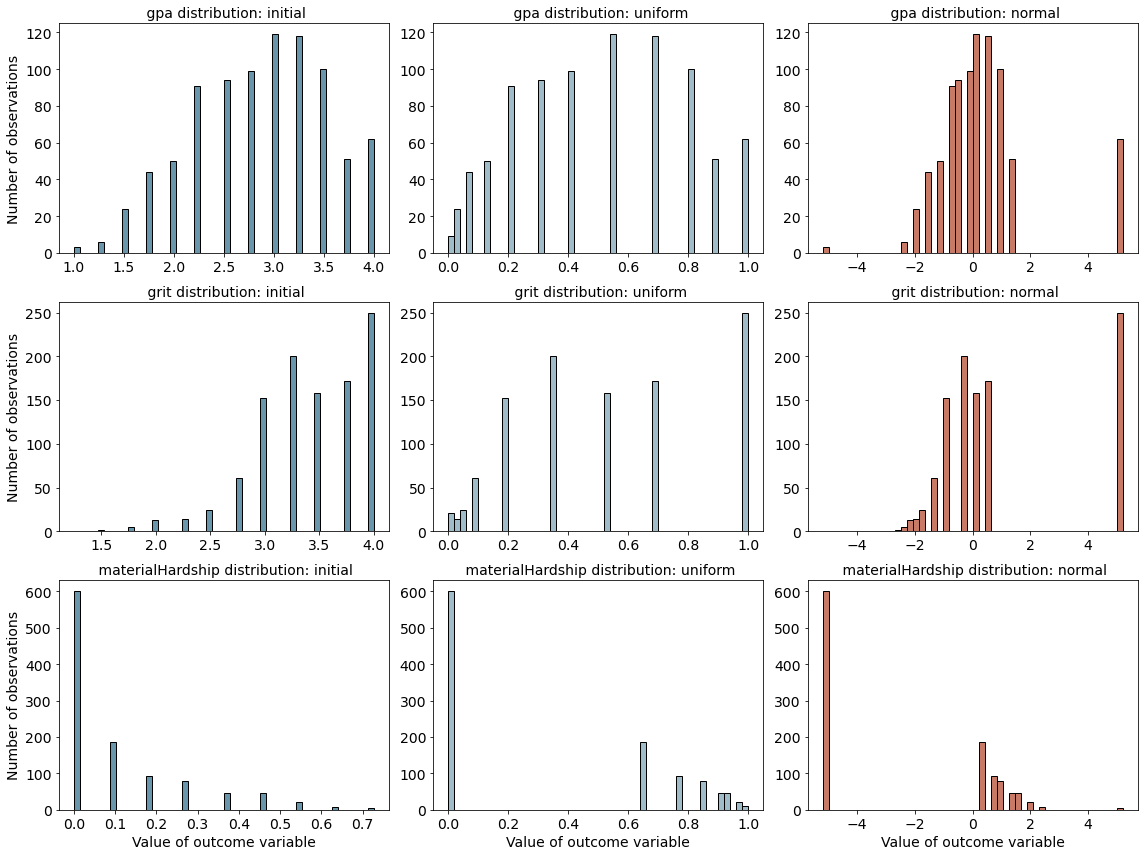

In [735]:
fig, axs = plt.subplots(3,3, figsize=(16,12))

for nr, outcome in enumerate(['gpa', 'grit', 'materialHardship']):
    
    # Initialize transforms
    qt_uniform = QuantileTransformer(n_quantiles=50, output_distribution='uniform')
    qt_normal = QuantileTransformer(n_quantiles=50, output_distribution='normal')
    
    # Get distributions
    y_train = y_trains[[outcome]]
    y_train_uniform = qt_uniform.fit_transform(y_train)
    y_train_normal = qt_normal.fit_transform(y_train)
    
    axs[nr, 0].hist(y_train[outcome], color=c1, bins=50, linewidth=1, edgecolor='black');
    axs[nr, 1].hist(y_train_uniform, color=c2, bins=50, linewidth=1, edgecolor='black');
    axs[nr, 2].hist(y_train_normal, color=c4, bins=50, linewidth=1, edgecolor='black');

    for i, name in enumerate(['initial', 'uniform', 'normal']):
        axs[nr, i].set_title(f" {outcome} distribution: {name}", fontsize=fontsize)

        for tick in axs[nr, i].xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        for tick in axs[nr, i].yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
     
        if nr == 2: axs[nr, i].set_xlabel(f"Value of outcome variable", fontsize=fontsize)
        if i == 0: axs[nr, i].set_ylabel("Number of observations", fontsize=fontsize)
            
plt.tight_layout()
fig.savefig('distributions_transform.png')

### 2.5.2. Visualizing GPA transformation

In [235]:
outcome = 'gpa'

In [237]:
qt_uniform = QuantileTransformer(n_quantiles=50, output_distribution='uniform')
qt_normal = QuantileTransformer(n_quantiles=50, output_distribution='normal')

# Get distributions
y_train = y_trains[[outcome]]
y_train_uniform = qt_uniform.fit_transform(y_train)
y_train_normal = qt_normal.fit_transform(y_train)


In [245]:
y_train = y_train.loc[y_train['gpa'].notnull(), 'gpa']

In [255]:
y_cumsum = y_train.cumsum()
xrange = np.arange(0,len(y_cumsum), 1)

In [395]:
# Set number of bins
n_bins=13

# Get the base line values
values, base2 = np.histogram(y_train, bins=n_bins)
_, base = np.histogram(y_train, bins=12)
cumulative = np.cumsum(values)

# Get normal distribution
normdist = np.random.normal(0, 1, 10000000)
values1, base1 = np.histogram(normdist, bins=n_bins)
cumulative_norm = np.cumsum(values1)

# Uniform
unidist = np.random.uniform(0, 1, 10000000)
values2, base2 = np.histogram(unidist, bins=n_bins)
cumulative_uni = np.cumsum(values2)


In [485]:
c5 = '#C1553A'

In [515]:
from matplotlib.lines import Line2D

In [614]:
normal_patch = mpatches.Patch(color=c1, label='Variable distribution')
custom_line = Line2D([0], [0], color=c4, marker='o', lw=1, label='Cumulative distribution')


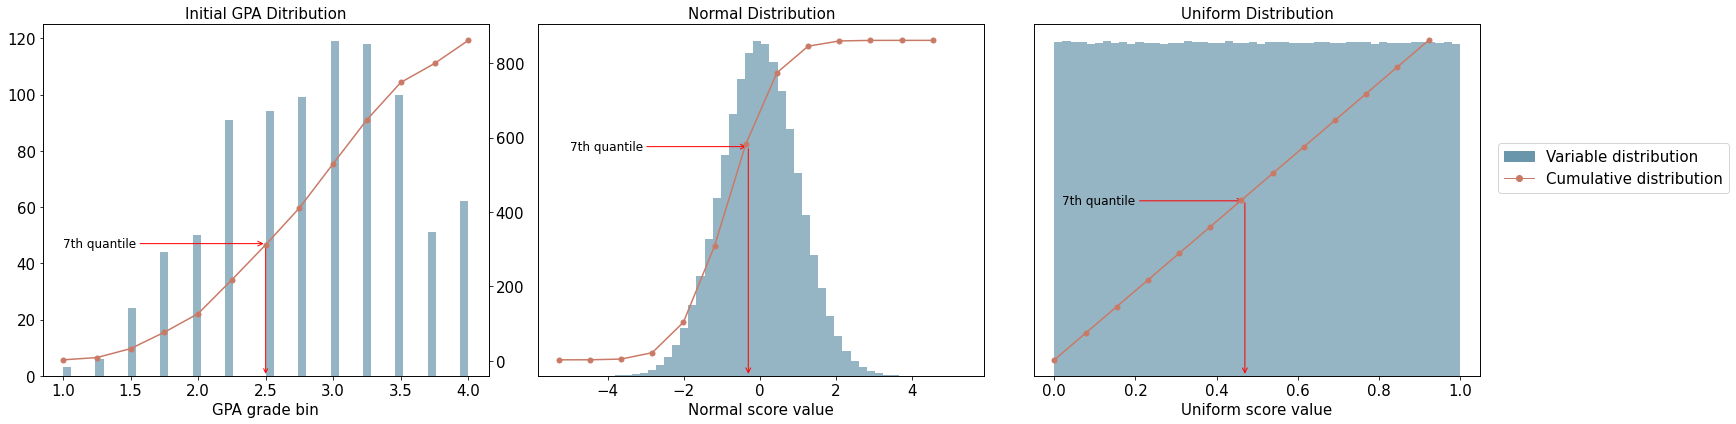

In [631]:
fontsize=15
alpha=0.7
fig, axs = plt.subplots(1,3, figsize=(24,6))


axs[0].hist(y_train, bins=50, color=c1, label='GPA distribution', alpha=alpha)
axs0 = axs[0].twinx()
axs0.plot(base, cumulative, color=c4, marker='o', markersize=5, label='GPA cumulative count')

#axs[0].legend()
axs[0].set_title("Initial GPA Ditribution", fontsize=fontsize)

# Second plot
axs[1].hist(normdist, bins=50, color=c1, alpha=alpha)
axs1 = axs[1].twinx()
axs1.plot(base1[:-1], cumulative_norm, color=c4, markersize=5, marker='o')

axs[1].set_title("Normal Distribution", fontsize=fontsize)
axs[1].set_xlabel("Normal score value", fontsize=fontsize)
axs[1].set_ylabel("")
axs1.set_ylabel("")
axs[1].set_yticks([])
axs1.set_yticks([])

axs[2].hist(unidist, bins=50, color=c1, alpha=alpha)
axs2 = axs[2].twinx()
axs2.plot(base2[:-1], cumulative_uni, color=c4, markersize=5, marker='o')

axs[2].set_title("Uniform Distribution", fontsize=fontsize)
axs[2].set_yticks([])
axs2.set_yticks([])
axs[2].set_ylabel("")
axs2.set_ylabel("")
axs[2].set_xlabel("Uniform score value", fontsize=fontsize)

# Change tick sizes
for ax in axs:
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
        
for ax in [axs0, axs1, axs2]:
    for tick in ax.yaxis.get_major_ticks(): tick.label2.set_fontsize(fontsize)

axs[0].set_xlabel("GPA grade bin", fontsize=fontsize)
axs0.set_xlabel("Cumulative GPA", fontsize=fontsize)


# Depict 7th quantile

# Plot 1
axs[0].annotate('7th quantile', xy=(2.5,47), xytext=(1,47),
            arrowprops={'arrowstyle': '->', 'color':'red'}, va='center', fontsize=12)

axs[0].annotate('', xy=(2.5,0), xytext=(2.5,47),
            arrowprops={'arrowstyle': '->', 'color': 'red'}, va='center', color=c2)


# Plot 2
n2 = 580000
axs[1].annotate('7th quantile', xy=(-0.3,n2), xytext=(-5,n2),
            arrowprops={'arrowstyle': '->', 'color':'red'}, va='center', fontsize=12)
axs[1].annotate('', xy=(-0.3,0), xytext=(-0.3,n2),
            arrowprops={'arrowstyle': '->', 'color':'red'}, va='center', fontsize=12)

# Plot 3
axs[2].annotate('7th quantile', xy=(0.47,105000), xytext=(0.02,105000),
            arrowprops={'arrowstyle': '->', 'color':'red'}, va='center', fontsize=12)
axs[2].annotate('', xy=(0.47,0), xytext=(0.47,105000),
            arrowprops={'arrowstyle': '->', 'color':'red'}, va='center', fontsize=12)

#axs[0].annotate('', xy=(2.5,0), xytext=(2.5,47),
#            arrowprops={'arrowstyle': '->', 'facecolor': 'black'}, va='center', color=c2)

plt.legend(handles=[normal_patch, custom_line], loc = 'lower center',
           frameon=True, fontsize=fontsize,
          bbox_to_anchor=(1.3, 0.5))

plt.tight_layout()
fig.savefig('distribution_quantiles_map.png')

In [484]:
import matplotlib
from matplotlib import patches as mpatches

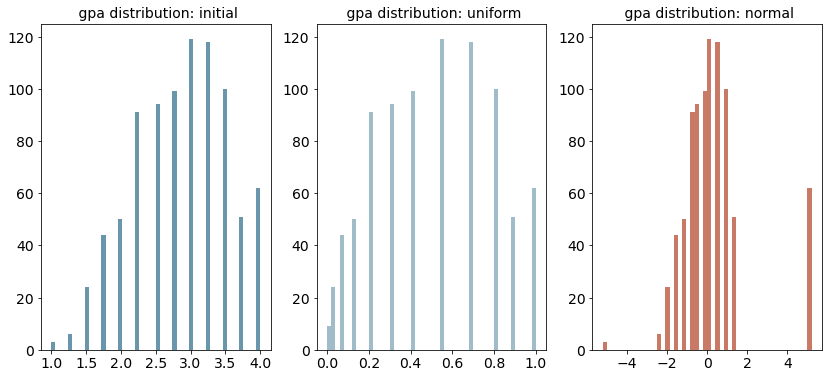

In [216]:
fig, axs = plt.subplots(1,3, figsize=(14,6))

axs[0].hist(y_train[outcome], color=c1, bins=50);
axs[1].hist(y_train_uniform, color=c2, bins=50);
axs[2].hist(y_train_normal, color=c4, bins=50);

for i, name in enumerate(['initial', 'uniform', 'normal']):
    axs[i].set_title(f" {outcome} distribution: {name}", fontsize=fontsize)

    for tick in axs[i].xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in axs[i].yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)

### 2.5.3. Calculating Lasso Quantile R^2

In [170]:
col = X_train_q.columns[100]

In [632]:
def get_lasso_results(output_dist):
    
    # Create instances for output distributions
    qt_x = QuantileTransformer(n_quantiles=50, output_distribution=output_dist)
    qt_y = QuantileTransformer(n_quantiles=50, output_distribution=output_dist)
    
    test_errors = {}
    test_rsquared = {}
    for outcome in ['gpa', 'grit', 'materialHardship']:

        # Create a list for storing results
        test_errors[outcome] = []
        test_rsquared[outcome] = []

        print(f"Outcome: {outcome}")

        # Let's drop instances where the response is NA
        y_train = y_trains[outcome].dropna()
        X_train = X_trains.loc[y_train.index.values]

        # Convert y to dataframe
        y_train = pd.DataFrame(y_train)
        y_cv = pd.DataFrame(y_cvs[outcome])

        # Fit Quantile transformer (I don't need to remove NAs from X_cv since I filter them later)
        X_train_q = qt_x.fit_transform(X_train)
        X_cv_q = qt_x.transform(X_cv)

        # Reconvert to dataframe
        X_train_q = pd.DataFrame(X_train_q, columns=X_train.columns)
        X_cv_q = pd.DataFrame(X_cv_q, columns=X_cv.columns)

        # Fit Quantile to Y variable
        y_train_q = qt_y.fit_transform(y_train)
        y_cv_q = qt_y.transform(y_cv)
        
        
        
        # Get alphas
        alphas = np.logspace(-5,1,20)

        for i, a in enumerate(alphas):

            if i % 30 == 0:
                print(f"Alpha iteration {i}")

            # Fit the model
            model = Lasso(alpha=a, max_iter=100_000)
            model.fit(X_train_q, y_train_q)

            # Make the predictions
            y_pred_q = pd.DataFrame(model.predict(X_cv_q))
            y_pred = qt_y.inverse_transform(y_pred_q)

            # Get the min or max value
            min_value = min_max_values[outcome]['min']
            max_value = min_max_values[outcome]['max']

            # Get the predictions
            y_pred = np.clip(y_pred,min_value,max_value)

            # Get the non-null predictions
            y_cv_true = [y for x, y in zip(y_pred, y_cvs[outcome]) if not math.isnan(y)]
            y_pred_true = [x for x, y in zip(y_pred, y_cvs[outcome]) if not math.isnan(y)]

            # Calculate the scores
            mse = mean_squared_error(y_cv_true, y_pred_true)
            r2 = r2_score(y_cv_true, y_pred_true)

            # Append the values
            test_errors[outcome].append(mse)
            test_rsquared[outcome].append(r2)

    return test_errors, test_rsquared

In [633]:
test_errors_uniform, test_rsquared_uniform = get_lasso_results('uniform')

Outcome: gpa
Alpha iteration 0
Outcome: grit
Alpha iteration 0
Outcome: materialHardship
Alpha iteration 0


In [661]:
colormap = {outcome: c for outcome, c in zip(outcomes, [c1, c2, c4])}

In [666]:
alphas_plot1 = np.logspace(-5,1,50)
alphas_plot2 = np.logspace(-5, 1, 20)

In [706]:
np.array(test_rsquared_uniform['gpa']).max()

0.1192151714532459

In [723]:
np.array(test_rsquared_uniform['gpa']).argmax()

9

In [736]:
np.array(alphas_plot1)

array([1.00000000e-05, 1.32571137e-05, 1.75751062e-05, 2.32995181e-05,
       3.08884360e-05, 4.09491506e-05, 5.42867544e-05, 7.19685673e-05,
       9.54095476e-05, 1.26485522e-04, 1.67683294e-04, 2.22299648e-04,
       2.94705170e-04, 3.90693994e-04, 5.17947468e-04, 6.86648845e-04,
       9.10298178e-04, 1.20679264e-03, 1.59985872e-03, 2.12095089e-03,
       2.81176870e-03, 3.72759372e-03, 4.94171336e-03, 6.55128557e-03,
       8.68511374e-03, 1.15139540e-02, 1.52641797e-02, 2.02358965e-02,
       2.68269580e-02, 3.55648031e-02, 4.71486636e-02, 6.25055193e-02,
       8.28642773e-02, 1.09854114e-01, 1.45634848e-01, 1.93069773e-01,
       2.55954792e-01, 3.39322177e-01, 4.49843267e-01, 5.96362332e-01,
       7.90604321e-01, 1.04811313e+00, 1.38949549e+00, 1.84206997e+00,
       2.44205309e+00, 3.23745754e+00, 4.29193426e+00, 5.68986603e+00,
       7.54312006e+00, 1.00000000e+01])

In [737]:
best_alpha = np.array(alphas_plot2)[np.array(test_rsquared_uniform['gpa']).argmax()]

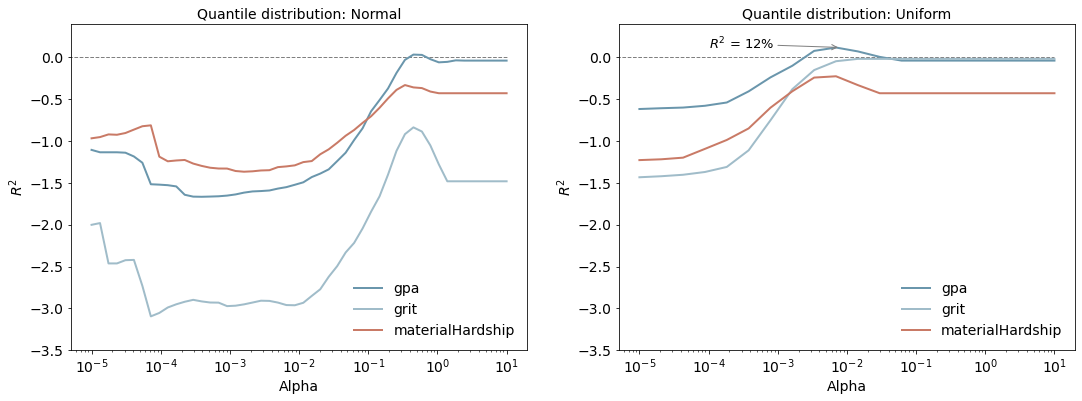

In [720]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
lwidth = 2
fontsize=14
for outcome in outcomes:
    axs[0].plot(alphas_plot1, pd.Series(test_rsquared_normal[outcome]), linewidth=lwidth, label=outcome, color=colormap[outcome])
    axs[1].plot(alphas_plot2, pd.Series(test_rsquared_uniform[outcome]), linewidth=lwidth, label=outcome, color=colormap[outcome])

axs[0].set_title("Quantile distribution: Normal", fontsize=fontsize)
axs[1].set_title("Quantile distribution: Uniform", fontsize=fontsize)

axs[1].annotate('$R^2$ = 12%', xy=(10**(-2.1),0.12), xytext=(10**(-4), 0.16),
            arrowprops={'arrowstyle': '->', 'color': 'grey'}, va='center', fontsize=13)

for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel("Alpha", fontsize=fontsize)
    axs[i].set_ylabel("$R^2$", fontsize=fontsize)
    axs[i].hlines(0, 0, 10, linewidth=1, color='grey', linestyles='--')
    axs[i].set_ylim((-3.5, 0.4))
    for tick in axs[i].xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in axs[i].yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
        
    axs[i].legend(frameon=False, loc='lower right', fontsize=fontsize)
    
fig.savefig('quant_dist_results.png')

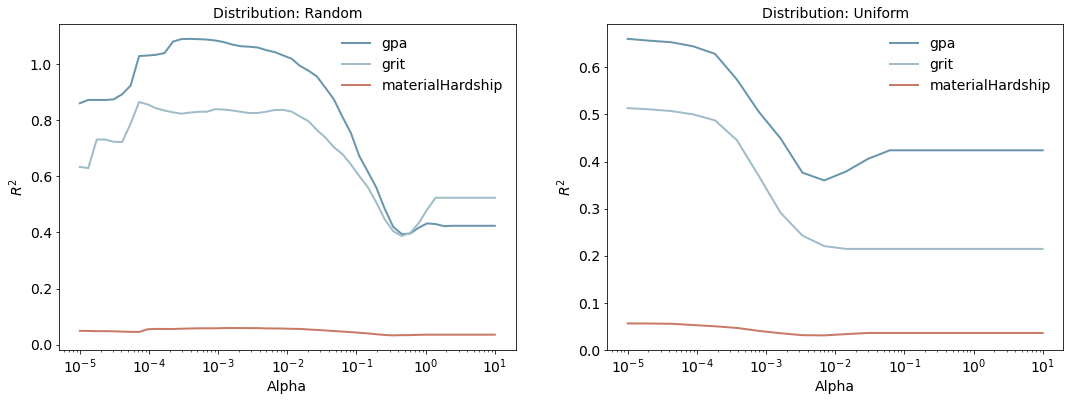

In [702]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
lwidth = 2
fontsize=14
for outcome in outcomes:
    axs[0].plot(alphas_plot1, pd.Series(test_errors_normal[outcome]), linewidth=lwidth, label=outcome, color=colormap[outcome])
    axs[1].plot(alphas_plot2, pd.Series(test_errors_uniform[outcome]), linewidth=lwidth, label=outcome, color=colormap[outcome])

axs[0].set_title("Distribution: Random", fontsize=fontsize)
axs[1].set_title("Distribution: Uniform", fontsize=fontsize)

for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel("Alpha", fontsize=fontsize)
    axs[i].set_ylabel("$R^2$", fontsize=fontsize)
    #axs[i].set_ylim((-3.5, 0.4))
    for tick in axs[i].xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in axs[i].yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
        
    axs[i].legend(frameon=False, loc='upper right', fontsize=fontsize)

### 2.5.4. Testing Quantile model on leaderboard data

In [739]:
best_alpha = np.array(alphas_plot2)[np.array(test_rsquared_uniform['gpa']).argmax()]

In [743]:
output_dist='uniform'

In [754]:
# Create instances for output distributions
qt_x = QuantileTransformer(n_quantiles=50, output_distribution=output_dist)
qt_y = QuantileTransformer(n_quantiles=50, output_distribution=output_dist)

outcome = 'gpa'

y_train = y_trains[outcome].dropna()
X_train = X_trains.loc[y_train.index.values]

# Convert y to dataframe
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(leaderboard[outcome])

# Fit Quantile transformer
X_train_q = qt_x.fit_transform(X_train)

# Get X_test
X_test = df.loc[y_test.index]

# Fill in NAs with training mean
X_test = X_test.fillna(X_train.mean())

# Transform
X_test_q = qt_x.transform(X_test)

# Reconvert to dataframe
X_train_q = pd.DataFrame(X_train_q, columns=X_train.columns)
X_test_q = pd.DataFrame(X_test_q, columns=X_test.columns)

# Fit Quantile to Y variable
y_train_q = qt_y.fit_transform(y_train)
y_test_q = qt_y.transform(y_test)

In [762]:
y_cv_true = [y for x, y in zip(y_pred, y_test[outcome]) if not math.isnan(y)]


In [770]:
model = Lasso(alpha=best_alpha, max_iter=100_000)
model.fit(X_train_q, y_train_q)

# Make the predictions
y_pred_q = pd.DataFrame(model.predict(X_test_q))
y_pred = qt_y.inverse_transform(y_pred_q)

# Get the min or max value
min_value = min_max_values[outcome]['min']
max_value = min_max_values[outcome]['max']

# Get the predictions
y_pred = np.clip(y_pred,min_value,max_value)

# Get the non-null predictions
y_cv_true = [y for x, y in zip(y_pred, np.array(y_test[outcome])) if not math.isnan(y)]
y_pred_true = [x for x, y in zip(y_pred, np.array(y_test[outcome])) if not math.isnan(y)]

# Calculate the scores
mse = mean_squared_error(y_cv_true, y_pred_true)
r2 = r2_score(y_cv_true, y_pred_true)


In [773]:
r2

0.052856337387803154

In [136]:
pd.DataFrame(test_errors_uniform).to_csv('./data/lasso_uniform_test_err.csv')
pd.DataFrame(test_rsquared_uniform).to_csv('./data/lasso_uniform_test_rsquared.csv')

In [137]:
test_errors_normal, test_rsquared_normal = get_lasso_results('normal')

Outcome: gpa
Alpha iteration 0
Alpha iteration 30
Outcome: grit
Alpha iteration 0
Alpha iteration 30
Outcome: materialHardship
Alpha iteration 0
Alpha iteration 30


In [138]:
pd.DataFrame(test_errors_normal).to_csv('./data/lasso_normal_test_err.csv')
pd.DataFrame(test_rsquared_normal).to_csv('./data/lasso_normal_test_rsquared.csv')

In [143]:
outcomes = ['gpa', 'grit', 'materialHardship']

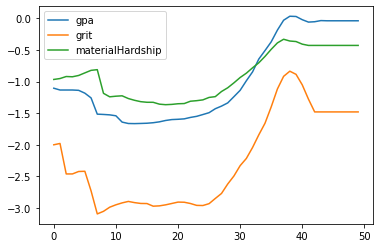

In [648]:
fig, ax = plt.subplots(1,2,)
for outcome in outcomes:
    ax.plot(pd.Series(test_rsquared_normal[outcome]), label=outcome)
    
    
ax.legend()

# 3. LightGBM

## 3.1. Setup and initialization of random search

In [585]:
df = pd.read_csv('./data/transformed_data_all.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

# Renaming since some packages throws errors
df = df.rename(columns = lambda x:re.sub('>', 'morethan', x))
df = df.rename(columns = lambda x:re.sub('<', 'lessthan', x))
df = df.rename(columns = lambda x:re.sub(':', '_', x))


In [586]:
df = df.set_index("challengeID")

In [587]:
df_train = df.loc[train.index]

In [588]:
df_train = df_train.fillna(df_train.mean())

In [589]:
params_lgbm ={'num_leaves': sp_randint(4, 30), 
             'n_estimators': sp_randint(50,1500),
             'learning_rate': [0.01, 0.02, 0.05],
             'max_depth': sp_randint(2, 8),
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 20],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20]}

In [568]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [573]:
clf = lgb.LGBMRegressor(random_state=42, silent=True, metric=None, n_jobs=4, force_col_wise=True)

In [582]:
gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params_lgbm, 
    n_iter=n_HP_points_to_test,
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=42,
    verbose=True)

In [584]:
for outcome in ['materialHardship']:
    
    print(f"Outcome: {outcome}")
    # Let's drop instances where the response is NA
    y_train = train[outcome].dropna()
    X_train = df_train.loc[y_train.index.values]
    
    # Randomized Search
    gs.fit(X_train, y_train, eval_metric='neg_mean_squared_error')
    
    pd.DataFrame(gs.cv_results_).to_csv(f'./data/LightGBM_{outcome}.csv')

Outcome: materialHardship
Fitting 3 folds for each of 50 candidates, totalling 150 fits


## 3.2. Fitting Categorical variables lightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
df = pd.read_csv('./data/transformed_data_all.csv')

train = pd.read_csv('./FFChallenge_V5/train.csv', sep=',', header=0, index_col=0)


# Renaming since some packages throws errors
df = df.rename(columns = lambda x:re.sub('>', 'morethan', x))
df = df.rename(columns = lambda x:re.sub('<', 'lessthan', x))
df = df.rename(columns = lambda x:re.sub(':', '_', x))


In [605]:
df = df.set_index("challengeID")
df_train = df.loc[train.index]
df_train = df_train.fillna(df_train.mean())

In [606]:
params_lgbm ={'num_leaves': sp_randint(4, 30), 
             'n_estimators': sp_randint(50,1000),
             'learning_rate': [0.01, 0.02, 0.05],
             'max_depth': sp_randint(2, 8),
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 20],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20]}

In [612]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50



In [613]:
clf = lgb.LGBMClassifier(random_state=42, silent=True, class_weight='balanced', force_col_wise=True)

In [614]:
gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params_lgbm, 
    n_iter=n_HP_points_to_test,
    scoring=['neg_brier_score', 'f1', 'precision', 'recall'],
    n_jobs=3,
    cv=3,
    refit='neg_brier_score',
    random_state=42,
    verbose=True)

In [615]:
for outcome in ['jobTraining', 'layoff', 'eviction']:

    print(f"Outcome: {outcome}")
    # Let's drop instances where the response is NA
    y_train = train[outcome].dropna()
    X_train = df_train.loc[y_train.index.values]

    # Randomized Search
    gs.fit(X_train, y_train)

    pd.DataFrame(gs.cv_results_).to_csv(f'./data/LightGBM_{outcome}.csv')

Outcome: jobTraining
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: layoff
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: eviction
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Posting this code below that was used for the actual evaluation of the algorithm (so that the CV data would always be imputed by the mean of the train folds)

In [ ]:
# Get numeric transformations to NA
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

# Get RF
LGBM = LGBMClassifier(class_weight='balanced')

# Setup pipeline
pipe_LGBM = Pipeline([('transformer', numeric_transformer), ('LGBM', LGBM)])

# Set up GridSearch
LGBM_grid = RandomSearchCV(estimator=pipe_LGBM,
                   param_grid=grid_LGBM_params,
                   scoring=['neg_brier_score', 'f1'],
                   refit='neg_brier_score',
                   cv=3)

# Fit the grid
LGBM_grid.fit(X_train, train_y)

## 3.3. Predicting continuous variables

In [ ]:
for outcome in ['eviction', 'layoff', 'jobTraining']:

  print(f"Outcome: {outcome}")
  # Let's drop instances where the response is NA
  y_train = train[outcome].dropna()
  X_train = df_train.loc[y_train.index.values]

  # Randomized Search
  gs.fit(X_train, y_train)

  pd.DataFrame(gs.cv_results_).to_csv(f'./LightGBM_{outcome}.csv')

## 3.4. Evaluating LightGBM Performance

In [105]:
datafolder = '.'

In [120]:
eval_variable = 'rank_test_neg_brier_score'

for outcome in ['eviction', 'layoff', 'jobTraining']:
    gbm_eviction = pd.read_csv(f'{datafolder}/LightGBM_{outcome}.csv')
    
    min_var = gbm_eviction[eval_variable].max()
    min_results = gbm_eviction.loc[gbm_eviction[eval_variable] == min_var, ['mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_neg_brier_score']]
    
    print(outcome)
    display(min_results)

eviction


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.259434,0.173386,0.528736,-0.170709


layoff


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.320738,0.239192,0.486891,-0.242383


jobTraining


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.400374,0.334546,0.516323,-0.232785


## 3.5. Visualizing the results of random grid search

### 3.5.1. Importing data

In [391]:
xgresults_gpa = pd.read_csv('./data/LightGBM_gpa.csv')
xgresults_grit = pd.read_csv('./data/LightGBM_grit.csv')
xgresults_mh = pd.read_csv('./data/LightGBM_materialHardship.csv')

In [424]:
outcomes = ['gpa', 'grit', 'materialHardship']
xgresults_all = [xgresults_gpa, xgresults_grit, xgresults_mh]
for outcome, xgresults in zip(outcomes, xgresults_all):
    print(f"Outcome: {outcome}")
    # Get the data
    X_train, y_train, X_leaderboard, y_leaderboard = get_data(outcome, train, leaderboard, scaled=False)

    # Get the params
    params = ast.literal_eval(xgresults.loc[xgresults.rank_test_score==1, 'params'].iloc[0])
    
    # Fit the model with the best params
    model = lgb.LGBMRegressor(random_state=42, silent=True, metric=None, n_jobs=4, force_col_wise=True, **params)
    model.fit(X_train, y_train, eval_metric='neg_mean_squared_error')

    # Get the predictions
    y_pred = model.predict(X_leaderboard)

    # Get the min or max value
    min_value = min_max_values[outcome]['min']
    max_value = min_max_values[outcome]['max']

    # Get the predictions
    y_pred = np.clip(y_pred,min_value,max_value)

    # Get the non-null predictions
    y_leaderboard_true = [y for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]
    y_pred_true = [x for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]

    # Calculate the score
    mse = mean_squared_error(y_leaderboard_true, y_pred_true)
    r2 = r2_score(y_leaderboard_true, y_pred_true)
    print(f"R-squared on leaderboard data: {r2}")
    print(f"MSE on leaderboard data: {mse}")

Outcome: gpa
R-squared on leaderboard data: 0.027257404590394163
MSE on leaderboard data: 0.37996891895740764
Outcome: grit
R-squared on leaderboard data: 0.004015971137374064
MSE on leaderboard data: 0.21885521339453806
Outcome: materialHardship
R-squared on leaderboard data: 0.1380946670312101
MSE on leaderboard data: 0.024655525158043607


In [612]:
xgresults_gpa.loc[xgresults_gpa.rank_test_score==1, 'params'].iloc[0]

"{'colsample_bytree': 0.4271363733463229, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 387, 'num_leaves': 18, 'reg_alpha': 5, 'reg_lambda': 0.1, 'subsample': 0.9722042458113105}"

In [836]:
xgresults_grit.loc[xgresults_grit.rank_test_score==1, 'params'].iloc[0]

"{'colsample_bytree': 0.9178620555253562, 'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 1121, 'num_leaves': 26, 'reg_alpha': 10, 'reg_lambda': 20, 'subsample': 0.46014665762139767}"

In [918]:
xgresults_mh.loc[xgresults_mh.rank_test_score==1, 'params'].iloc[0]

"{'colsample_bytree': 0.7642205486120108, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1230, 'num_leaves': 18, 'reg_alpha': 5, 'reg_lambda': 0, 'subsample': 0.21250912539295516}"

In [514]:
# Set colors
c1 = '#6A96AC'
c2 = '#A0BCC9'
c3 = '#D7E1E7'
c4 = '#C97A66'

In [518]:
mse_gpa = 0.37996891895740764
mse_grit = 0.21885521339453806
mse_mh = 0.024655525158043607

In [533]:
import matplotlib.patches as patches

In [534]:
rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

### 3.5.2. Plotting MSE

In [929]:
def plot_gpa_mse(ax, color=c1, fontsize=13):
    
    ax.hist(-xgresults_gpa['mean_test_score'], edgecolor='black', linewidth=1, color=color, bins=20)

    # Add a circle
    ax.set_ylim((0,10))
    ax.set_xlim((0.365,0.425))
    ax.annotate("  ", xy=(0.379, 8),  fontsize=14, color=c4, ha='center',
                bbox={'boxstyle': 'circle', 'pad': 0, 'facecolor': c4, 'edgecolor': 'black', 'alpha':0.8})
    ax.annotate("Best model leader-\nboard performance ", xy=(0.381, 7.63),  fontsize=12, color='black', ha='left')
    ax.axvspan(0.405, 0.44, alpha=0.35, color=c4)
    ax.annotate("Best features:", xy=(0.406, 9),  fontsize=fontsize, color='black', weight='bold', alpha=0.8, ha='left', va='top')
    ax.annotate("""
Colsample_bytree: 0.42
Learning_rate: 0.01
Max_depth: 6
N_estimators: 387,
Num_leaves: 18,
Reg_alpha: 5
Reg_lambda: 0.1,
Subsample: 0.97
    """, xy=(0.406, 9),  fontsize=fontsize, color='black', alpha=0.8, ha='left', va='top')
    
    ax.set_title("LightGBM Mean Squared Error Distribution on GPA", fontsize=fontsize)
    ax.set_ylabel("Model count", fontsize=fontsize)

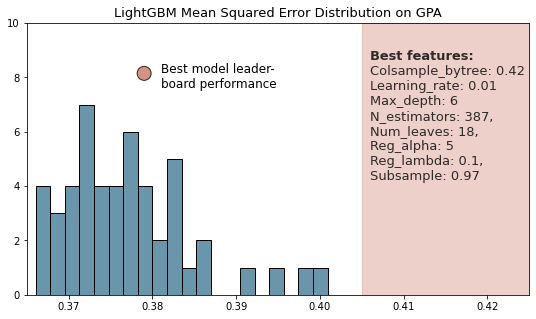

In [846]:
fig, ax = plt.subplots(figsize=(9,5))
plot_gpa_mse(ax)

In [930]:
def plot_grit_mse(ax, color=c2, fontsize=13):
    
    ax.hist(-xgresults_grit['mean_test_score'], edgecolor='black', linewidth=1, color=color, bins=20)

    # Add a circle
    ax.set_ylim((0,10))
    ax.set_xlim((0.215,0.253))
    ax.annotate("  ", xy=(0.21885521339453806, 7),  fontsize=14, color=c4, ha='center',
                bbox={'boxstyle': 'circle', 'pad': 0, 'facecolor': c4, 'edgecolor': 'black', 'alpha':0.8})
    ax.annotate("Best model leader-\nboard performance ", xy=(0.216, 7.9),  fontsize=12, color='black', ha='left')
    ax.axvspan(0.24, 0.253, alpha=0.35, color=c4)
    ax.annotate("Best features:", xy=(0.2405, 8.5),  fontsize=fontsize, color='black', weight='bold', alpha=0.8, ha='left', va='top')
    ax.annotate("""
Colsample_bytree: 0.91
Learning_rate: 0.02
Max_depth: 2
N_estimators: 1121,
Num_leaves: 26,
Reg_alpha: 10
Reg_lambda: 20,
Subsample: 0.46
    """, xy=(0.2405, 8.2),  fontsize=fontsize, color='black', alpha=0.8, ha='left', va='top')
    
    ax.set_title("LightGBM Mean Squared Error Distribution on Grit", fontsize=fontsize)
    ax.set_ylabel("Model count", fontsize=fontsize)

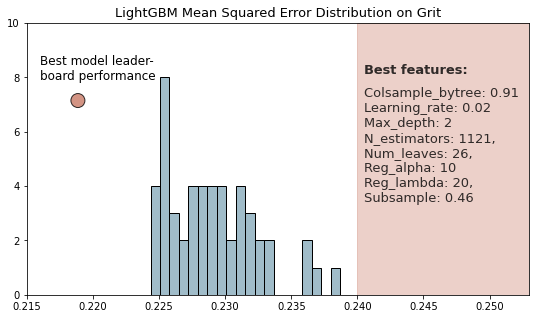

In [871]:
fig, ax = plt.subplots(1,1, figsize=(9, 5))
plot_grit_mse(ax, color=c2)

In [931]:
def plot_mh_mse(ax, color=c2, fontsize=13):
    
    ax.hist(-xgresults_mh['mean_test_score'], edgecolor='black', linewidth=1, color=color, bins=30)

    # Add a circle
    ax.set_ylim((0,16))
    ax.set_xlim((0.020,0.032))
    ax.annotate("  ", xy=(0.024655525158043607, 14),  fontsize=14, color=c4, ha='center',
                bbox={'boxstyle': 'circle', 'pad': 0, 'facecolor': c4, 'edgecolor': 'black', 'alpha':0.8})
    ax.annotate("Best model leader-\nboard performance ", xy=(0.025, 13.5),  fontsize=12, color='black', ha='left')
    ax.axvspan(0.028, 0.032, alpha=0.35, color=c4)
    ax.annotate("Best features:", xy=(0.0281, 15),  fontsize=fontsize, color='black', weight='bold', alpha=0.8, ha='left', va='top')
    ax.annotate("""
Colsample_bytree: 0.76
Learning_rate: 0.01
Max_depth: 2
N_estimators: 1230,
Num_leaves: 18,
Reg_alpha: 5
Reg_lambda: 0,
Subsample: 0.21
    """, xy=(0.0281, 15),  fontsize=fontsize, color='black', alpha=0.8, ha='left', va='top')
    
    ax.set_title("LightGBM Mean Squared Error Distribution on materialHardship", fontsize=fontsize)
    ax.set_xlabel("Mean squared error", fontsize=fontsize)
    ax.set_ylabel("Model count", fontsize=fontsize)

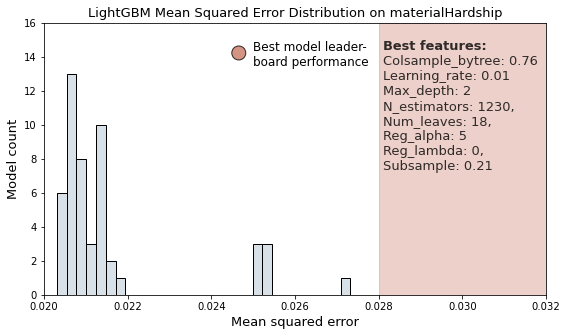

In [932]:
fig, ax = plt.subplots(1,1, figsize=(9, 5))
plot_mh_mse(ax, color=c3)

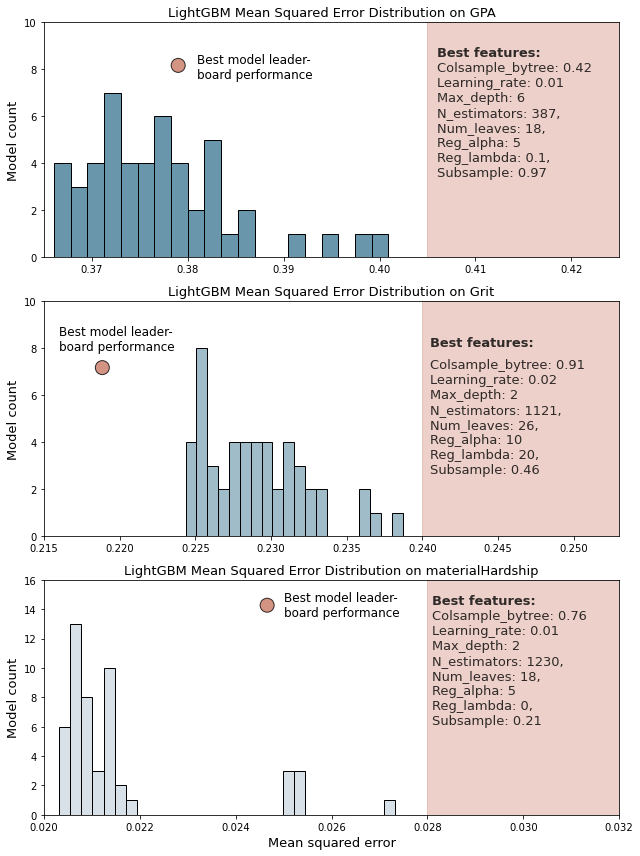

In [934]:
fig, axs = plt.subplots(3,1, figsize=(9, 12))

plot_gpa_mse(axs[0])
plot_grit_mse(axs[1])
plot_mh_mse(axs[2], color=c3)
plt.tight_layout()
fig.savefig('lightgbm_mse_eval.png')

In [368]:
best_params_xg = xgresults[xgresults['rank_test_score'] == 1]['params'].iloc[0]

In [369]:
xgresults[xgresults['rank_test_score'] == 1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,10,23.673044,1.253699,0.35655,0.011587,0.427136,0.01,6,387,18,5.0,0.1,0.972204,"{'colsample_bytree': 0.4271363733463229, 'lear...",-0.322623,-0.374798,-0.400717,-0.366046,0.032477,1


In [118]:
best_params_xg = ast.literal_eval(best_params_xg)

In [119]:
clf = lgb.LGBMRegressor(random_state=42, silent=True, metric=None, n_jobs=4, force_col_wise=True, **best_params_xg)

In [123]:
clf.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.4271363733463229, force_col_wise=True,
              learning_rate=0.01, max_depth=6, metric=None, n_estimators=387,
              n_jobs=4, num_leaves=18, random_state=42, reg_alpha=5,
              reg_lambda=0.1, subsample=0.9722042458113105)

In [124]:
y_pred = clf.predict(X_leaderboard)

In [125]:
y_pred = np.clip(y_pred,min_value,max_value)

In [126]:
# Get the non-null predictions
y_leaderboard_true = [y for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]
y_pred_true = [x for x, y in zip(y_pred, y_leaderboard) if not math.isnan(y)]

In [129]:
mse = mean_squared_error(y_leaderboard_true, y_pred_true)
r2 = r2_score(y_leaderboard_true, y_pred_true)

In [130]:
print(f"MSE: {mse}; R^2: {r2}")

MSE: 0.37996891895740764; R^2: 0.027257404590394163


# 4. Fitting  Lasso residuals with LightGBM

## 4.1. Fitting the model

In [496]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import sklearn
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [498]:
params_lgbm ={'num_leaves': sp_randint(4, 30), 
             'n_estimators': sp_randint(50,1500),
             'learning_rate': [0.01, 0.02, 0.05],
             'max_depth': sp_randint(2, 8),
             'subsample': sp_uniform(loc=0.2, scale=0.6), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.4)}

In [504]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 20


In [505]:
for outcome in ['grit', 'materialHardship']:
    
    print(f"Outcome: {outcome}")
    X_train_scaled, y_train, y_train_trans, X_leaderboard_scaled, y_leaderboard, y_train_mean, y_train_std, y_pred_trans = get_data(outcome, train, leaderboard)
    
    # Get min alpha
    min_mse = np.array(test_errs[outcome]).min()
    min_alpha = [alpha for mse, alpha in zip(test_errs[outcome], np.logspace(-3,3,200)) if mse ==min_mse][0]

    # Fit the model
    model = Lasso(alpha=min_alpha, max_iter=100_000)
    model.fit(X_train_scaled, y_train_trans)

    # Get the predictions of train set
    y_pred_trans = model.predict(X_train_scaled)
    y_pred = y_train_mean + y_train_std*y_pred_trans

    # Get the min or max value
    min_value = min_max_values[outcome]['min']
    max_value = min_max_values[outcome]['max']

    # Get the predictions
    y_pred = np.clip(y_pred,min_value,max_value)

    # Get the non-null predictions
    y_train_true = [y for x, y in zip(y_pred, y_train) if not math.isnan(y)]
    y_pred_true = [x for x, y in zip(y_pred, y_train) if not math.isnan(y)]

    # Calculate residual
    resids = np.array(y_pred_true) - np.array(y_train_true)
    
    # Get model
    model = lgb.LGBMRegressor(random_state=42, silent=True, metric=None, force_col_wise=True)
    
    gs = RandomizedSearchCV(
            estimator=model,
            param_distributions=params_lgbm, 
            n_iter=n_HP_points_to_test,
            n_jobs = 4,
            scoring=['neg_mean_squared_error', 'r2'],
            cv=3,
            refit='neg_mean_squared_error',
            random_state=42,
            verbose=True)
    
    # Fit and export the randomized search
    gs.fit(X_train_scaled, resids, eval_metric='neg_mean_squared_error')
    
    pd.DataFrame(gs.cv_results_).to_csv(f'./data/Lasso_LightGBM_additional_runs_{outcome}.csv')

Outcome: grit
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Outcome: materialHardship
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [936]:
resids_dict = {}
for outcome in ['gpa', 'grit', 'materialHardship']:
    
    print(f"Outcome: {outcome}")
    X_train_scaled, y_train, y_train_trans, X_leaderboard_scaled, y_leaderboard, y_train_mean, y_train_std, y_pred_trans = get_data(outcome, train, leaderboard)
    
    # Get min alpha
    min_mse = np.array(test_errs[outcome]).min()
    min_alpha = [alpha for mse, alpha in zip(test_errs[outcome], np.logspace(-3,3,200)) if mse ==min_mse][0]

    # Fit the model
    model = Lasso(alpha=min_alpha, max_iter=100_000)
    model.fit(X_train_scaled, y_train_trans)

    # Get the predictions of train set
    y_pred_trans = model.predict(X_train_scaled)
    y_pred = y_train_mean + y_train_std*y_pred_trans

    # Get the min or max value
    min_value = min_max_values[outcome]['min']
    max_value = min_max_values[outcome]['max']

    # Get the predictions
    y_pred = np.clip(y_pred,min_value,max_value)

    # Get the non-null predictions
    y_train_true = [y for x, y in zip(y_pred, y_train) if not math.isnan(y)]
    y_pred_true = [x for x, y in zip(y_pred, y_train) if not math.isnan(y)]

    # Calculate residual
    resids = np.array(y_pred_true) - np.array(y_train_true)
    resids_dict[outcome] = resids

Outcome: gpa
Outcome: grit
Outcome: materialHardship


## 4.2. Plotting residuals

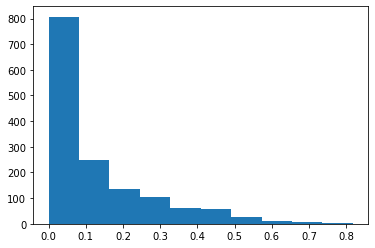

In [946]:
fig, ax = plt.subplots()

ax.hist(pd.Series(y_train));

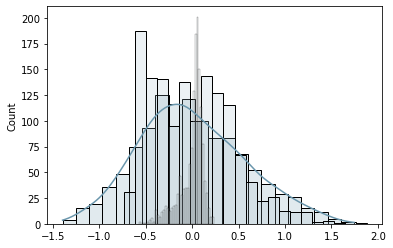

In [958]:
fig, ax = plt.subplots()

sns.histplot(pd.Series(resids_dict['gpa']), ax=ax, color=c1, alpha=0.2, kde=True);
sns.histplot(pd.Series(resids_dict['grit']), ax=ax, color=c2, alpha=0.2);
sns.histplot(pd.Series(resids_dict['materialHardship']), ax=ax, color=c3, alpha=0.2);

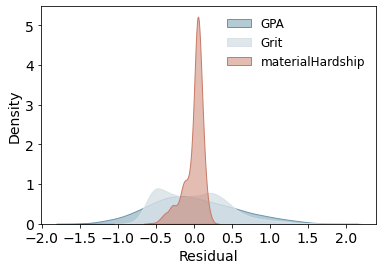

In [988]:
fig, ax = plt.subplots()

sns.kdeplot(pd.Series(resids_dict['gpa']), ax=ax, label='GPA', color=c1, alpha=0.5, fill=True)
sns.kdeplot(pd.Series(resids_dict['grit']), ax=ax, color=c3, label='Grit', alpha=0.8, fill=True);
sns.kdeplot(pd.Series(resids_dict['materialHardship']), ax=ax, label = 'materialHardship', color=c4, alpha=0.5, fill=True);

ax.set_xlabel("Residual", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
ax.legend(frameon=False, fontsize=12)
fig.savefig('residual_dist.png')

## 4.3. Getting the data for residual fits

In [989]:
resid_gpa = pd.read_csv("./data/Lasso_LightGBM_gpa.csv")

In [995]:
resid_grit1 = pd.read_csv("./data/Lasso_LightGBM_grit.csv")
resid_grit2 = pd.read_csv("./data/Lasso_LightGBM_additional_runs_grit.csv")
resid_grit = pd.concat([resid_grit1, resid_grit2]).reset_index()

resid_mh1 = pd.read_csv("./data/Lasso_LightGBM_materialHardship.csv")
resid_mh2 = pd.read_csv("./data/Lasso_LightGBM_additional_runs_materialHardship.csv")
resid_mh = pd.concat([resid_mh1, resid_mh2]).reset_index()


In [1110]:
resids_all = [resid_gpa, resid_grit, resid_mh]

In [1012]:
resid_gpa.columns

Index(['Unnamed: 0', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_colsample_bytree', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_num_leaves',
       'param_reg_alpha', 'param_reg_lambda', 'param_subsample', 'params',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')

In [1014]:
min_r2 = np.array(resid_gpa['mean_test_r2']).min()

In [1020]:
params_lowest_r2 = ast.literal_eval(resid_gpa[resid_gpa['mean_test_r2'] == min_r2]['params'].iloc[0])

In [1021]:
params_lowest_r2

{'colsample_bytree': 0.9295818059136038,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 1306,
 'num_leaves': 6,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.885059433502474}

In [1023]:
outcome = 'gpa'

## 4.4. Fitting residuals on the leaderborad data

In [1024]:
print(f"Outcome: {outcome}")
X_train_scaled, y_train, y_train_trans, X_leaderboard_scaled, y_leaderboard, y_train_mean, y_train_std, y_pred_trans = get_data(outcome, train, leaderboard)

# Get min alpha
min_mse = np.array(test_errs[outcome]).min()
min_alpha = [alpha for mse, alpha in zip(test_errs[outcome], np.logspace(-3,3,200)) if mse ==min_mse][0]

# Fit the model
model = Lasso(alpha=min_alpha, max_iter=100_000)
model.fit(X_train_scaled, y_train_trans)

# Get the predictions of train set
y_pred_trans = model.predict(X_train_scaled)
y_pred = y_train_mean + y_train_std*y_pred_trans

# Get the min or max value
min_value = min_max_values[outcome]['min']
max_value = min_max_values[outcome]['max']

# Get the predictions
y_pred = np.clip(y_pred,min_value,max_value)

# Get the non-null predictions
y_train_true = [y for x, y in zip(y_pred, y_train) if not math.isnan(y)]
y_pred_true = [x for x, y in zip(y_pred, y_train) if not math.isnan(y)]

# Calculate residual
resids = np.array(y_pred_true) - np.array(y_train_true)



Outcome: gpa


In [1028]:
# Get model
model = lgb.LGBMRegressor(random_state=42, silent=True, metric=None, force_col_wise=True, **params_lowest_r2)

In [1026]:
model.fit(X_train_scaled, resids)

LGBMRegressor(colsample_bytree=0.9295818059136038, force_col_wise=True,
              learning_rate=0.05, max_depth=2, metric=None, n_estimators=1306,
              num_leaves=6, random_state=42, reg_alpha=1, reg_lambda=1,
              subsample=0.885059433502474)

In [ ]:
model.predict(X_train_scaled)

In [1036]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

In [1030]:
preds = cross_val_predict(model, X_train_scaled, resids)

In [1034]:
r2_score(preds, resids)

-6.09632618696395

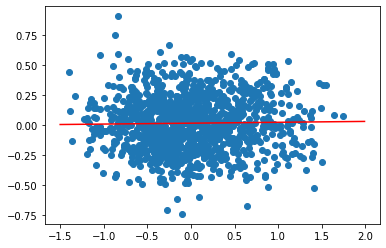

In [1043]:
fig, ax = plt.subplots()

ax.scatter(resids, preds)
m, b = np.polyfit(resids, preds, deg=1)

x = np.arange(-1.5,2,0.01)
ax.plot(x, m*x + b, color='red')

## 4.5. Calculating t-test statistic for whether there is any relationship between the predicted and real residuals

In [1044]:
from scipy.stats import ttest_ind

In [1045]:
ttest_ind(resids, preds)

Ttest_indResult(statistic=-0.8748848205998909, pvalue=0.38172682868250063)

In [1140]:
ccode = {0: c1, 1:c2, 2:c3}

## 4.6. Plotting residual predictions for each group

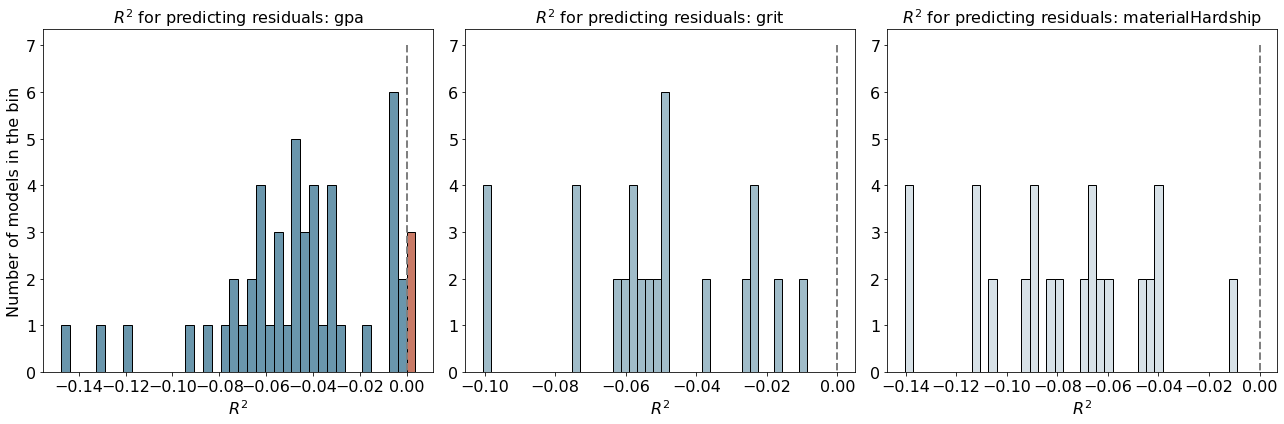

In [1142]:
fig, axs = plt.subplots(1,3, figsize=(18,6))
fontsize=16
for i, k in enumerate(zip(outcomes, resids_all)):
    
    # Get outcome and resids
    
    outcome = k[0]
    resid = k[1]
    n, bin1, patches = axs[i].hist(resid['mean_test_r2'], bins=40, linewidth=1, edgecolor='black', color=ccode[i])
    
    axs[i].vlines(0, 7, 0, linewidth=2, color='grey', linestyles='--')

    # Change the color of the last bin
    if i == 0: patches[-1].set_fc(c4)
        
    axs[i].set_title(f"$R^2$ for predicting residuals: {outcome}", fontsize=fontsize)
    axs[i].set_xlabel("$R^2$", fontsize=fontsize)
    if i == 0: axs[i].set_ylabel("Number of models in the bin", fontsize=fontsize)
    for tick in axs[i].xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in axs[i].yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
        
plt.tight_layout()
fig.savefig('residual_predictions.png')

# 5. Running LightGBM, RF, and RF + MI

## 5.1. Setup

In [574]:
lightgbm_dict = {}
RF = {}
RF_MI = {}

In [575]:
for outcome in ['jobtraining', 'layoff', 'eviction']:
    lightgbm_dict[outcome] = pd.read_csv(f'./data/LightGBM_{outcome}.csv')
    RF[outcome] = pd.read_csv(f'./data/RF_{outcome}.csv')
    RF_MI[outcome] = pd.read_csv(f'./data/RF_MI_{outcome}.csv')

In [576]:
datasets = [lightgbm_dict, RF, RF_MI]

In [204]:
lightgbm['jobtraining'].keys()

Index(['Unnamed: 0', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_colsample_bytree', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_num_leaves',
       'param_reg_alpha', 'param_reg_lambda', 'param_subsample', 'params',
       'split0_test_neg_brier_score', 'split1_test_neg_brier_score',
       'split2_test_neg_brier_score', 'mean_test_neg_brier_score',
       'std_test_neg_brier_score', 'rank_test_neg_brier_score',
       'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'mean_test_recall',
       'std_test_recall', 'rank_test_recall'],
      dtype='object')

In [62]:
# Set colors
c1 = '#3F5A67'
c2 = '#A0BCC9'
c3 = '#D7E1E7'
c4 = '#C97A66'

In [63]:
outcomes = ['eviction', 'jobtraining', 'layoff']

In [64]:
colorcode = {k:v for k,v in zip(outcomes, [c1, c2, c4])}

## 5.2. Plotting the brier loss

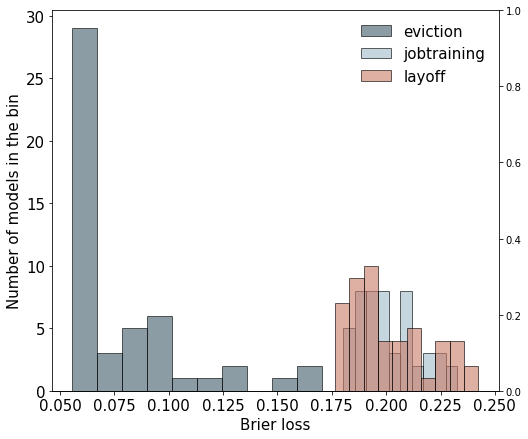

In [214]:
fontsize=15

fig, ax = plt.subplots(1,1, figsize=(8,7))

ax2 = ax.twinx()
for outcome in outcomes:
    ax.hist(-lightgbm_dict[outcome]['mean_test_neg_brier_score'], label=outcome, color=colorcode[outcome], alpha=0.6, linewidth=1, edgecolor='black')
ax.set_xlabel("Brier loss", fontsize=fontsize)
ax.set_ylabel("Number of models in the bin", fontsize=fontsize)
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

for sp in ['right', 'top', 'left']: 
    ax.spines[sp].set_visible(False)

ax.legend(loc='upper right', frameon=False, fontsize=fontsize)
fig.savefig('brier_loss_lightgbm.png')


## 5.3. Evaluating the model on the leaderboard

In [ ]:
df = pd.read_csv('./data/transformed_data_all.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
leaderboard = pd.read_csv('FFChallenge_v5/leaderboard.csv', sep=',', header=0, index_col=0)

In [146]:
# Renaming since some packages throws errors
df = df.rename(columns = lambda x:re.sub('>', 'morethan', x))
df = df.rename(columns = lambda x:re.sub('<', 'lessthan', x))
df = df.rename(columns = lambda x:re.sub(':', '_', x))


In [147]:
outcome = 'eviction'

In [216]:
clf = lgbm.LGBMClassifier(random_state=42, class_weight='balanced', force_col_wise=True, **best_params)

In [217]:
from sklearn.metrics import f1_score, brier_score_loss

In [224]:
maxval = lightgbm_dict[outcome]['rank_test_neg_brier_score'].max()
best_params = ast.literal_eval(lightgbm_dict[outcome].loc[lightgbm_dict[outcome]['rank_test_neg_brier_score'] == maxval, 'params'].iloc[0])


In [225]:
model='LGBM'

In [226]:
# Get classifier
if model == 'LGBM':
    clf = lgbm.LGBMClassifier(random_state=42, class_weight='balanced', force_col_wise=True, **best_params)


In [235]:
def evaluate_leaderboard(outcome, lightgbm_dict, model='LGBM'):
    
    # Get model params
    maxval = lightgbm_dict[outcome]['rank_test_neg_brier_score'].max()
    best_params = ast.literal_eval(lightgbm_dict[outcome].loc[lightgbm_dict[outcome]['rank_test_neg_brier_score'] == maxval, 'params'].iloc[0])

    # Get classifier
    if model == 'LGBM':
        clf = lgbm.LGBMClassifier(random_state=42, class_weight='balanced', force_col_wise=True, **best_params)
    
    if outcome == 'jobtraining': outcome = 'jobTraining'
    train_y = train[outcome]
    train_y = train_y.dropna()
    
    leaderboard_y = leaderboard[outcome]
    leaderboard_y = leaderboard_y.dropna()
    
    X_train = df.loc[train_y.index]
    X_leaderboard = df.loc[leaderboard_y.index]
    
    # Get means
    means = X_train.mean()
    X_train = X_train.fillna(means)
    X_leaderboard = X_leaderboard.fillna(means)
    
    # Fit classifier
    clf.fit(X_train, train_y)
    
    # Get predictions
    preds = clf.predict(X_leaderboard)
    
    
    # Print losses
    print("Brier loss:")
    bloss = brier_score_loss(preds, leaderboard_y)
    print(bloss)
    
    print("F1: ")
    f1 = f1_score(preds, leaderboard_y)
    print(f1)
    
    return bloss, f1

In [236]:
results = {}
for outcome in outcomes:
    print(outcome)
    bloss, f1 = evaluate_leaderboard(outcome, lightgbm_dict, model='LGBM')
    results[outcome] = (bloss, f1)

eviction
Brier loss:
0.2528301886792453
F1: 
0.0821917808219178
jobtraining
Brier loss:
0.48867924528301887
F1: 
0.3508771929824561
layoff
Brier loss:
0.5320754716981132
F1: 
0.23369565217391308


In [246]:
results['eviction']

(0.2528301886792453, 0.0821917808219178)

In [259]:
pd.DataFrame(results).round(2)

,eviction,jobtraining,layoff
0,0.25,0.49,0.53
1,0.08,0.35,0.23


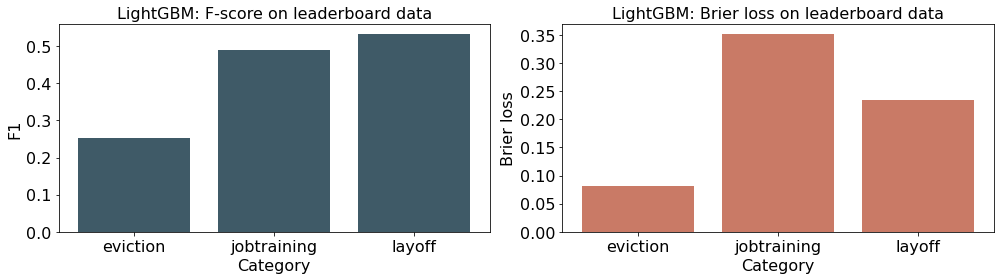

In [257]:
fontsize=16
fig, axs = plt.subplots(1,2, figsize=(14,4))

axs_list = axs.flatten()

for i, ax in enumerate(axs_list):
    
    ax.set_xlabel("Category", fontsize=fontsize)
    if i == 0: ax.set_ylabel("F1", fontsize=fontsize)
    if i == 1: ax.set_ylabel("Brier loss", fontsize=fontsize)

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    
    f1s = []
    briers = []
    for outcome in outcomes:
        f1s.append(results[outcome][0])
        briers.append(results[outcome][1])
    
    if i == 0: ax.bar(outcomes, f1s, label='outcome', color=c1)
    if i == 1: ax.bar(outcomes, briers, label='outcome', color=c4)
    
axs[0].set_title("LightGBM: F-score on leaderboard data", fontsize=fontsize)
axs[1].set_title("LightGBM: Brier loss on leaderboard data", fontsize=fontsize)

plt.tight_layout()
#fig.savefig('lightgbm_leaderboard_categ.png')

In [748]:
f1s

[0.2528301886792453, 0.48867924528301887, 0.5320754716981132]

In [749]:
briers

[0.0821917808219178, 0.3508771929824561, 0.23369565217391308]

In [761]:
res = pd.DataFrame([f1s, briers]).transpose()
res.columns = ['Brier Loss', 'F1']

In [762]:
res.index = ['eviction', 'jobTraining', 'Layoff']

In [763]:
res.round(2).to_latex('brier_score_lightgbm.tex')

## 5.4. Random Forest prediction (legacy)

This is not used in the final paper because the trees were too deep and could nfind relationships

In [70]:
n_HP_points_to_test = 50


In [71]:
params_rf ={
    
    # Number of trees in the forest
    'n_estimators': sp_randint(50,2000), 
    
    # Max depth of a tree
    'max_depth': sp_randint(8, 120)}
  

In [73]:
def initialize_random_search(RF, params_rf, n_HP_points_to_test):
    
    gs = RandomizedSearchCV(
        estimator=RF,
        param_distributions=params_rf, 
        n_iter=n_HP_points_to_test,
        scoring=['neg_brier_score', 'f1', 'precision', 'recall'],
        n_jobs=3,
        cv=3,
        refit='neg_brier_score',
        random_state=42,
        verbose=True)
    
    return gs

In [74]:
for outcome in ['eviction', 'layoff', 'jobTraining']:
    
    # Get RF
    RF = RandomForestClassifier(class_weight='balanced', random_state=42)

    # Get random search
    gs = initialize_random_search(RF, params_rf, n_HP_points_to_test)
    
    # Get X_train and y_train with dropped NAs
    print(f"Outcome: {outcome}")
    y_train = train[outcome].dropna()
    X_train = df_train.loc[y_train.index.values]

    # Randomized Search
    gs.fit(X_train, y_train)
    
    pd.DataFrame(gs.cv_results_).to_csv(f'./RF_{outcome}.csv')

Outcome: eviction
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: layoff
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: jobTraining
Fitting 3 folds for each of 50 candidates, totalling 150 fits


## 5.5. Plotting the historical RF data (legacy)

The data trained here was trained on bad hyperparameters (really deep forests that performed badly). This is why the results are like this. They are not included in the paper

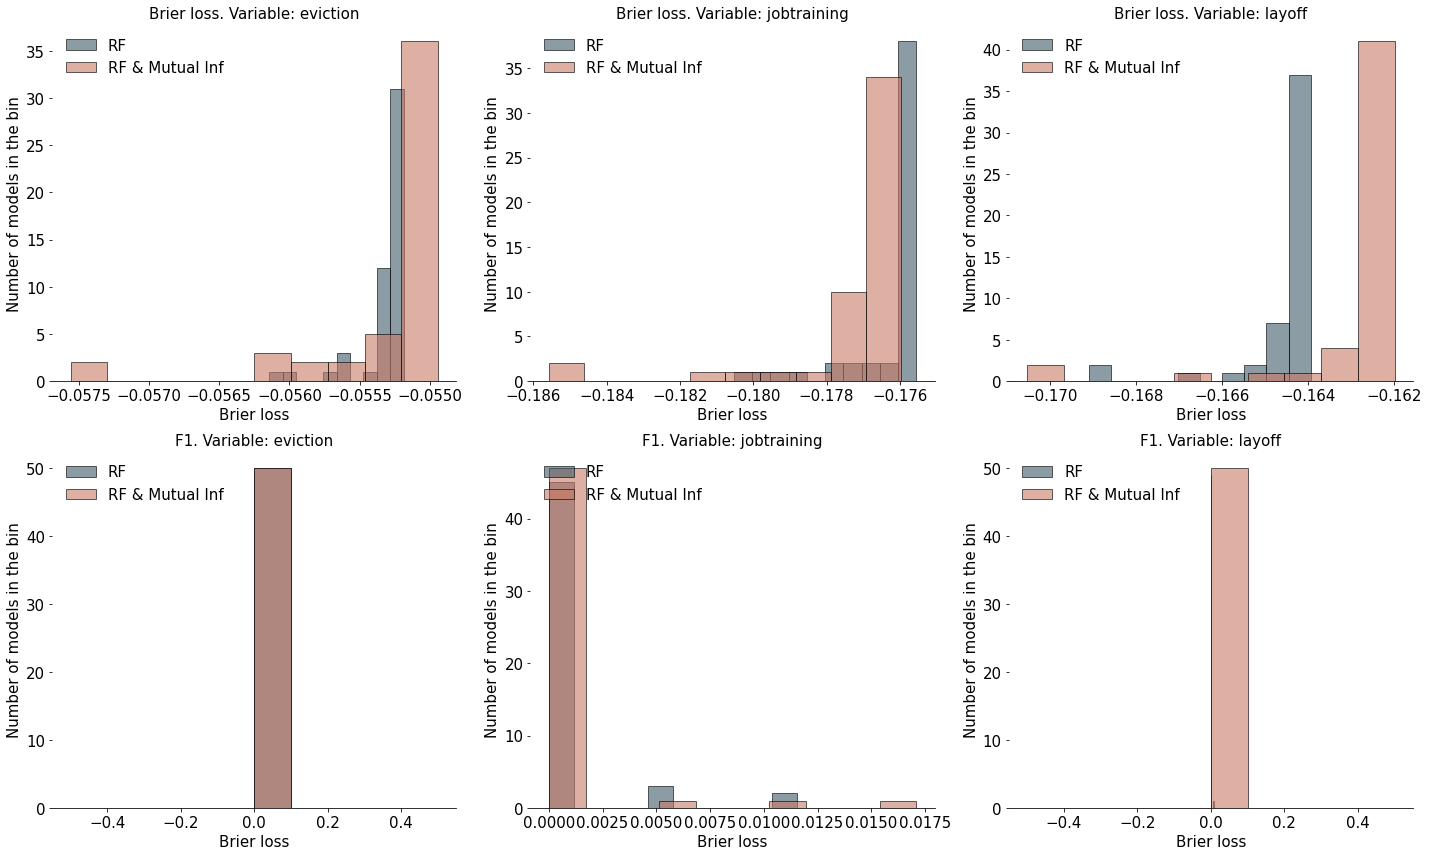

In [276]:
fontsize=15

fig, axs = plt.subplots(2,3, figsize=(20,12))

axs_list = axs.flatten()

for i, outcome in enumerate(outcomes):
    
    # Brier loss
    ax = axs_list[i]
    ax.hist(RF[outcome]['mean_test_neg_brier_score'], label='RF', color=c1, alpha=0.6, linewidth=1, edgecolor='black')
    ax.hist(RF_MI[outcome]['mean_test_neg_brier_score'], label='RF & Mutual Inf', color=c4, alpha=0.6, linewidth=1, edgecolor='black')
    
    ax.set_title(f"Brier loss. Variable: {outcome}", fontsize=fontsize)
    ax.set_xlabel("Brier loss", fontsize=fontsize)
    ax.set_ylabel("Number of models in the bin", fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)

    ax.legend(loc='upper left', frameon=False, fontsize=fontsize)
    
    # F1 score
    
    ax = axs_list[i+3]
    ax.hist(RF[outcome]['mean_test_f1'], label='RF', color=c1, alpha=0.6, linewidth=1, edgecolor='black')
    ax.hist(RF_MI[outcome]['mean_test_f1'], label='RF & Mutual Inf', color=c4, alpha=0.6, linewidth=1, edgecolor='black')
    
    ax.set_title(f"F1. Variable: {outcome}", fontsize=fontsize)
    ax.set_xlabel("Brier loss", fontsize=fontsize)
    ax.set_ylabel("Number of models in the bin", fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 

    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)

    ax.legend(loc='upper left', frameon=False, fontsize=fontsize)
    
fig.savefig('brier_loss_RF.png')

    
plt.tight_layout()

## 5.6. Classification with grid search

In [476]:
df = pd.read_csv('./data/transformed_data.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
leaderboard = pd.read_csv('FFChallenge_v5/leaderboard.csv', sep=',', header=0, index_col=0)

In [477]:
# Renaming since some packages throws errors
df = df.rename(columns = lambda x:re.sub('>', 'morethan', x))
df = df.rename(columns = lambda x:re.sub('<', 'lessthan', x))
df = df.rename(columns = lambda x:re.sub(':', '_', x))


In [478]:
outcomes = ['eviction', 'jobTraining', 'layoff']

In [479]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [494]:
# Get grid ssearch results
grid_RF_params = {'RF__max_depth': [1, 2, 5, 7, 10, 15, 20, 40],
             'RF__max_features': [50, 100,200,500,1000,2000]}

In [556]:
# Get grid ssearch results
grid_RF_params = {'RF__max_depth': [1,2,5,7,10],
             'RF__max_features': [1,2]}

In [557]:
import sklearn

In [558]:
for outcome in outcomes:
    print(f"Outcome variable: {outcome}")
    
    # Get the data
    train_y = train[outcome]
    train_y = train_y.dropna()

    leaderboard_y = leaderboard[outcome]
    leaderboard_y = leaderboard_y.dropna()

    X_train = df.loc[train_y.index]
    X_leaderboard = df.loc[leaderboard_y.index]

    # Get numeric transformations to NA
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    # Get RF
    RF = RandomForestClassifier(class_weight='balanced')

    # Setup pipeline
    pipe_RF = Pipeline([('transformer', numeric_transformer), ('RF', RF)])
    
    # Set up GridSearch
    rf_grid = GridSearchCV(estimator=pipe_RF,
                       param_grid=grid_RF_params,
                       scoring=['neg_brier_score', 'f1'],
                       refit='neg_brier_score',
                       cv=3)
    
    # Fit the grid
    rf_grid.fit(X_train, train_y)
    
    # Export results
    res = pd.DataFrame(rf_grid.cv_results_)
    res.to_csv(f'./data/RF_grid_nofuncforms__additional_{outcome}.csv')

Outcome variable: eviction
Outcome variable: jobTraining
Outcome variable: layoff


## 5.7. Mutual Information Regression

In [487]:
from sklearn.feature_selection import mutual_info_regression


In [561]:
# Get grid ssearch results
grid_RF_params = {'RF__max_depth': [1, 2, 5, 7, 10, 20],
             'RF__max_features': [1, 2, 5, 10, 20, 50, 100]}

In [564]:
for outcome in outcomes:
    print(f"Outcome variable: {outcome}")
    
    # Get the data
    train_y = train[outcome]
    train_y = train_y.dropna()

    leaderboard_y = leaderboard[outcome]
    leaderboard_y = leaderboard_y.dropna()

    X_train = df.loc[train_y.index]
    X_leaderboard = df.loc[leaderboard_y.index]

    # Get numeric transformations to NA
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    
    # Get copy of X (for MI calculation)
    X_train2 = X_train.copy()
    X_train2 = X_train2.fillna(X_train2.mean())
    
    # Get MI
    MI = []
    for var_ in X_train.columns:
        MI.append(mutual_info_regression(X_train2.loc[:,[var_]], train_y))
    
    # Get only the values that are more than zero
    mi_dict = defaultdict()
    for mi, col in zip(MI, X_train.columns):
        if mi != 0:
            mi_dict[col] = mi
            
    # Get the features
    features = nlargest(200, mi_dict, key = mi_dict.get)
    
    # Get RF
    RF = RandomForestClassifier(class_weight='balanced')

    # Setup pipeline
    pipe_RF = Pipeline([('transformer', numeric_transformer), ('RF', RF)])
    
    # Set up GridSearch
    rf_grid = GridSearchCV(estimator=pipe_RF,
                       param_grid=grid_RF_params,
                       scoring=['neg_brier_score', 'f1'],
                       refit='neg_brier_score',
                       cv=3)
    
    # Fit the grid
    rf_grid.fit(X_train[features], train_y)
    
    # Export results
    res = pd.DataFrame(rf_grid.cv_results_)
    res.to_csv(f'./data/RF_grid_nofuncforms_MI_{outcome}.csv')

Outcome variable: eviction
Outcome variable: jobTraining
Outcome variable: layoff


In [75]:
n_features=400

In [76]:
for outcome in ['eviction', 'layoff', 'jobTraining']:
    
    # Get RF
    RF = RandomForestClassifier(class_weight='balanced', random_state=42)

    # Get random search
    gs = initialize_random_search(RF, params_rf, n_HP_points_to_test)
        
    # Get X_train and y_train with dropped NAs
    print(f"Outcome: {outcome}")
    y_train = train[outcome].dropna()
    X_train = df_train.loc[y_train.index.values]

    # Get Mutual information
    MI = []
    for var_ in X_train.columns:
        MI.append(mutual_info_regression(X_train.loc[:,[var_]], y_train))
    
    # Get only the values that are more than zero
    mi_dict = defaultdict()
    for mi, col in zip(MI, X_train.columns):
        if mi != 0:
            mi_dict[col] = mi
            
    # Get the features
    features = nlargest(n_features, mi_dict, key = mi_dict.get)
    
    # Randomized Search
    gs.fit(X_train[features], y_train)
    
    pd.DataFrame(gs.cv_results_).to_csv(f'./RF_MI_{outcome}.csv')

Outcome: eviction
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: layoff
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Outcome: jobTraining
Fitting 3 folds for each of 50 candidates, totalling 150 fits


## 5.8. Visualizing Random Forest without Mutual Information

In [593]:
heatmaps = {}
for outcome in ['jobTraining', 'eviction', 'layoff']:
    eviction_df = pd.read_csv(f'./data/RF_grid_nofuncforms_{outcome}.csv')
    int_df = eviction_df[['param_RF__max_depth', 'param_RF__max_features', 'mean_test_f1']] 
    ptb = pd.pivot_table(data=int_df, index='param_RF__max_depth', columns='param_RF__max_features', values='mean_test_f1').fillna(0)
    
    heatmaps[outcome]  = ptb

In [594]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

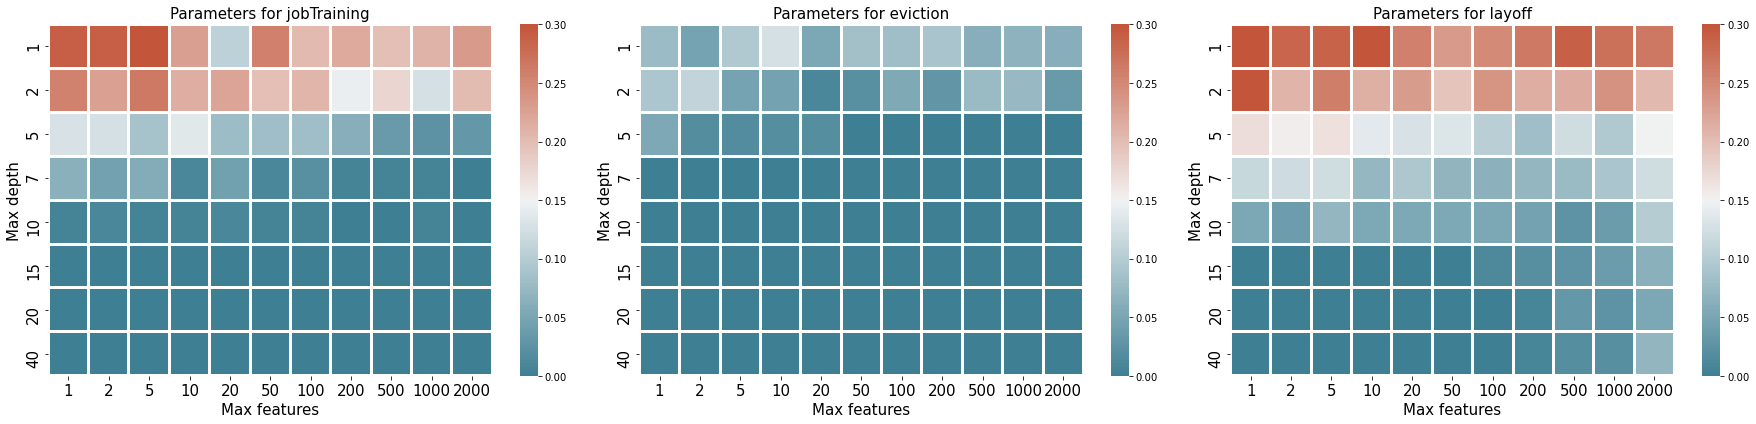

In [597]:
fontsize=15
fig, axs = plt.subplots(1,3, figsize=(25,6))
#sns.heatmap(ptb, cmap=cmap, linewidth=2)
for ax, hm in zip(axs, heatmaps.items()):
    outcome, ptb = hm
    sns.heatmap(ptb, cmap=cmap, linewidth=2, ax=ax, vmin=0, vmax=.30)
    ax.set_xlabel("Max features", fontsize=fontsize)
    ax.set_ylabel("Max depth", fontsize=fontsize)
    ax.set_title(f"Parameters for {outcome}", fontsize=fontsize)
    
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        
plt.tight_layout()
fig.savefig('rf_optimizations.png')

## 5.9. Visualizing Random Forest with Mutual Information

In [599]:
heatmaps = {}
for outcome in ['jobTraining', 'eviction', 'layoff']:
    eviction_df = pd.read_csv(f'./data/RF_grid_nofuncforms_MI_{outcome}.csv')
    int_df = eviction_df[['param_RF__max_depth', 'param_RF__max_features', 'mean_test_f1']] 
    ptb = pd.pivot_table(data=int_df, index='param_RF__max_depth', columns='param_RF__max_features', values='mean_test_f1').fillna(0)
    
    heatmaps[outcome]  = ptb

In [600]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

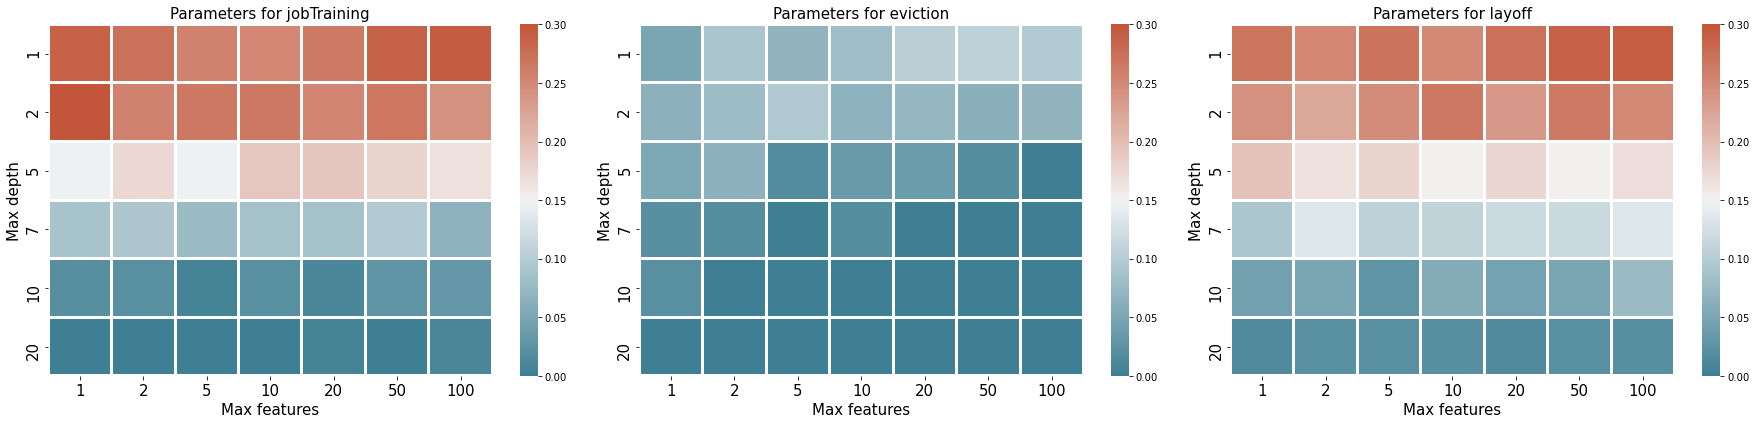

In [601]:
fontsize=15
fig, axs = plt.subplots(1,3, figsize=(25,6))
#sns.heatmap(ptb, cmap=cmap, linewidth=2)
for ax, hm in zip(axs, heatmaps.items()):
    outcome, ptb = hm
    sns.heatmap(ptb, cmap=cmap, linewidth=2, ax=ax, vmin=0, vmax=.30)
    ax.set_xlabel("Max features", fontsize=fontsize)
    ax.set_ylabel("Max depth", fontsize=fontsize)
    ax.set_title(f"Parameters for {outcome}", fontsize=fontsize)
    
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
        
plt.tight_layout()
fig.savefig('rf_optimizations2.png')

# 6. Classification - Ensemble model (by vote)

Model 1: LightGBM <br>
Model 2: RF <br>
Model 3: RF + MI <br>

Get the best params of all models

In [577]:
outcome = 'eviction'

In [633]:
lightgbm_dict[outcome].loc[lightgbm_dict[outcome]['mean_test_f1'] == maxf1, 'params']

29    {'colsample_bytree': 0.454173862032645, 'learn...
Name: params, dtype: object

Get train and test sets

In [646]:
df_all = pd.read_csv('./data/transformed_data_all.csv')
df = pd.read_csv('./data/transformed_data.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

In [ ]:
lightgbm_dict['jobTraining'] = lightgbm_dict.pop('jobtraining')


In [726]:
results_f1 = {}


In [728]:
for outcome in outcomes:
    print(f"Getting predictions for {outcome}")
    results_f1[outcome] = {}
    
    #################### Get the best parameters for that outcome variable ###################
        
    # Get max F1 - LightGBM
    maxf1= lightgbm_dict[outcome]['mean_test_f1'].max()
    params_gbm = ast.literal_eval(lightgbm_dict[outcome].loc[lightgbm_dict[outcome]['mean_test_f1'] == maxf1, 'params'].iloc[0])

    # Get max arg for RF
    rf = pd.read_csv(f'./data/RF_grid_nofuncforms_{outcome}.csv')
    params_rf = ast.literal_eval(rf.loc[rf.mean_test_f1 == rf.mean_test_f1.max(), 'params'].iloc[0])

    # Get RF prediction with MI
    rf_mi = pd.read_csv(f'./data/RF_grid_nofuncforms_MI_{outcome}.csv')
    params_rf_mi = ast.literal_eval(rf_mi.loc[rf_mi.mean_test_f1 == rf_mi.mean_test_f1.max(), 'params'].iloc[0])


     ################### Get Datasets  ###################
    # Get the data for y
    train_y = train[outcome]
    train_y = train_y.dropna()

    # Get leaderboard y
    leaderboard_y = leaderboard[outcome]
    leaderboard_y = leaderboard_y.dropna()

    # Get leaderboard X
    X_train = df.loc[train_y.index]
    X_leaderboard = df.loc[leaderboard_y.index]

    X_train_all = df_all.loc[train_y.index]
    X_leaderboard_all = df_all.loc[leaderboard_y.index]

    # Get numeric transformations to NA (one for each dataset)
    numeric_transformer1 = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    numeric_transformer2 = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    numeric_transformer3 = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    ############ Get RF ############
    RF = RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=1)

    # Setup pipeline
    pipe_RF = Pipeline([('transformer', numeric_transformer1), ('RF', RF)])

    # Fit the model
    pipe_RF.fit(X_train, train_y)
    
    ############ Get RF MI ############
    RF_MI = RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=100)

    # Setup pipeline
    pipe_RF2 = Pipeline([('transformer', numeric_transformer2), ('RF', RF_MI)])

    # Use the previous features
    pipe_RF2.fit(X_train[features], train_y)

    
    ############ Get LightGBM ############
    LightGBM = lgbm.LGBMClassifier(class_weight='balanced', **params_gbm)

    # Setup pipeline
    pipe_GBM = Pipeline([('transformer', numeric_transformer3), ('GBM', LightGBM)])

    # Fit the model
    pipe_GBM.fit(X_train_all, train_y)

    # Make predictions
    pred_RF = pipe_RF.predict(X_leaderboard)
    pred_RF_MI = pipe_RF2.predict(X_leaderboard[features])
    pred_GBM = pipe_GBM.predict(X_leaderboard_all)

    
    # If at least 2 vote in favor, then considered as 1
    pred_majority = (pred_RF + pred_RF_MI + pred_GBM) >= 2
    pred_majority = np.array([1 if x else 0 for x in preds_majority])
    
    # Build a dictionary
    dict_models = {'RF': pred_RF,
               'RF MI': pred_RF_MI,
               'GBM': pred_GBM,
               'Ensemble': pred_majority}
    
    for model, evals in dict_models.items():
        results_f1[outcome][model] = f1_score(evals, leaderboard_y)

Getting predictions for eviction
Getting predictions for jobTraining
Getting predictions for layoff


In [731]:
results_f1 = pd.DataFrame(results_f1).transpose()

In [737]:
results_f1.round(2).to_latex('table_class.tex')

# 7. Shapley values

In [4]:
datafolder = '.'

In [6]:
eval_variable = 'rank_test_neg_brier_score'


In [7]:
for outcome in ['eviction', 'layoff', 'jobTraining']:
    gbm_eviction = pd.read_csv(f'{datafolder}/LightGBM_{outcome}.csv')
    
    min_var = gbm_eviction[eval_variable].max()
    min_results = gbm_eviction.loc[gbm_eviction[eval_variable] == min_var, ['mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_neg_brier_score']]
    
    print(outcome)
    display(min_results)

eviction


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.259434,0.173386,0.528736,-0.170709


layoff


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.320738,0.239192,0.486891,-0.242383


jobTraining


,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_neg_brier_score
29,0.400374,0.334546,0.516323,-0.232785


In [16]:
import ast

In [18]:
best_params = ast.literal_eval(gbm_eviction.loc[gbm_eviction[eval_variable] == min_var, 'params'].iloc[0])

In [20]:
import lightgbm as lgb

In [38]:
model = lgb.LGBMClassifier(random_state=42, silent=True, class_weight='balanced', n_jobs=4, **best_params)

In [29]:
from sklearn.model_selection import train_test_split

In [242]:
outcome = 'layoff'

In [243]:
train_x, test_x, train_y, test_y = train_test_split(df_train, train[outcome])

In [244]:
import shap

In [245]:
# Getting train x for shapley values mean imputation
train_x = train_x.fillna(train_x.mean())

In [246]:
# Remove NAs
train_y = train_y[train_y.notnull()]
train_x = train_x.loc[train_y.index]

In [247]:
model.fit(train_x, train_y)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.454173862032645,
               learning_rate=0.01, max_depth=2, n_estimators=173, n_jobs=4,
               num_leaves=9, random_state=42, reg_alpha=20, reg_lambda=10,
               subsample=0.886687043850976)

In [249]:
explainer = shap.TreeExplainer(model)

In [250]:
shap_values = explainer.shap_values(train_x)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


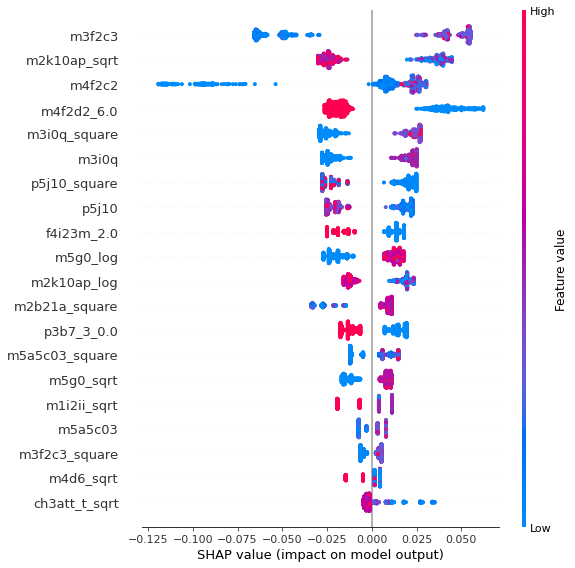

<Figure size 432x288 with 0 Axes>

In [251]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values[1], train_x, plot_type="dot")
fig.savefig(f'shap_dot_{outcome}.png')
plt.tight_layout()

In [252]:
outcome

'layoff'

In [229]:
# Set colors
c1 = '#6A96AC'
c2 = '#A0BCC9'
c3 = '#D7E1E7'
c4 = '#C97A66'

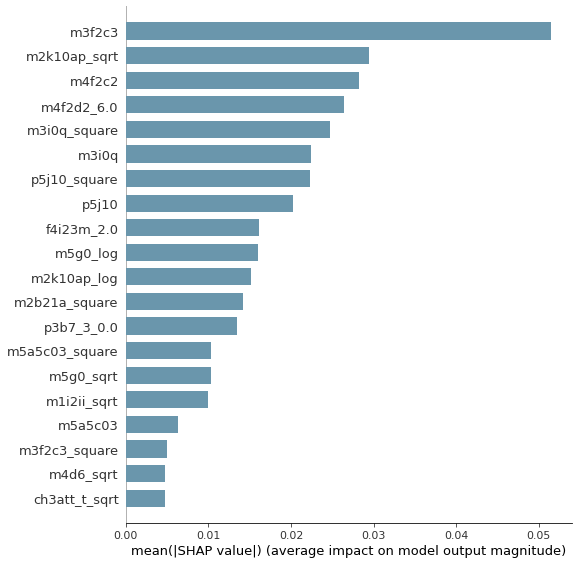

In [253]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values[1], train_x, plot_type="bar", color=c1)
fig.savefig(f'shap_bar_{outcome}.png')

In [198]:
shap.initjs()


In [199]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [141]:
# Get the predictions and put them with the test data.
X_output = train_x.copy()
X_output.loc[:,'predict'] = model.predict(X_output)

In [142]:
S = X_output.iloc[50]
S

cf1lenhr_sqrt      1.000000
cf1lenmin_sqrt     0.000000
f1citywt_sqrt     17.748176
f1a6a_sqrt         1.314810
cf1age_sqrt        4.582576
                    ...    
t5f5g_1.0          1.000000
t5f5g_2.0          0.000000
t5f5g_Other        0.000000
t5f5g_nan          0.000000
predict            1.000000
Name: 1122, Length: 21226, dtype: float64

In [256]:
shap.force_plot(explainer.expected_value[1], shap_values[1][20], features=train_x.iloc[10], feature_names=train_x.columns)


# 8. Do high leverage points impact bad predictions?

## 8.1. Fitting the model

1. Fit Lasso model on scaled data
2. Scale test data
3. Get predictions
4. Get residuals
5. Plot predictions vs real GPA
6. Highlight the points that are close to each other

1. Get Lasso model

In [ ]:
df = pd.read_csv('./data/transformed_data_all.csv')
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
leaderboard = pd.read_csv('FFChallenge_v5/leaderboard.csv', sep=',', header=0, index_col=0)

In [783]:
df = df.set_index("challengeID")

In [793]:
outcome = 'gpa'

In [798]:
y_train = train[outcome]
y_train = y_train.dropna()

In [799]:
y_test = leaderboard[outcome]
y_test = y_test.dropna()

In [804]:
X_train = df.loc[y_train.index]
X_test = df.loc[y_test.index]

means_x = X_train.mean()
X_train = X_train.fillna(means_x)
X_test = X_test.fillna(means_x)

In [810]:
# Scale the variables
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [811]:
# Change indices
X_train_scaled.index = X_train.index
X_test_scaled.index = X_test.index

In [812]:
# Scale the y variable
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train_trans = (y_train-y_train_mean)/y_train_std

In [813]:
with open('./data/test_errors.json') as f:
    test_errs = json.loads(f.read())

In [816]:
alphas = np.logspace(-3,3,200)


In [817]:
assert len(test_errs[outcome]) == len(alphas), 'Not equal length between alphas and test error'

In [822]:
lowest_alpha = alphas[np.array(test_errs[outcome]).argmin()]
print(f"Lowest alpha for {outcome}: {lowest_alpha}")

Lowest alpha for gpa: 0.08504489341802678


In [837]:
model = Lasso(random_state=42, alpha=lowest_alpha, max_iter=100_000)
model.fit(X_train_scaled, y_train_trans)

# Make the predictions
y_pred_trans = model.predict(X_test_scaled)
y_pred = y_train_mean + y_train_std*y_pred_trans

# Get the min or max value
min_value = min_max_values[outcome]['min']
max_value = min_max_values[outcome]['max']

# Get the predictions
y_pred = np.clip(y_pred,min_value,max_value)

# Get the non-null predictions
y_true = [y for x, y in zip(y_pred, y_test) if not math.isnan(y)]
y_pred_true = [x for x, y in zip(y_pred, y_test) if not math.isnan(y)]

# Calculate the scores
mse = mean_squared_error(y_true, y_pred_true)
r2 = r2_score(y_true, y_pred_true)


In [852]:
# Get x-axis
x = np.linspace(1,4.5,100)
y = np.linspace(1,4.5,100)

In [857]:
df_preds = pd.DataFrame([y_true, y_pred_true]).transpose()

In [858]:
df_preds.columns = ['y_true', 'y_pred']

In [860]:
df_preds['resid'] = abs(df_preds.y_true-df_preds.y_pred)

In [884]:
df_preds['low_resid'] = df_preds['resid'] < 0.15

In [890]:
def get_resid_level(df_preds, lambda_ = 0.15):
    if df_preds['resid'] < lambda_:
        return 'Small residual'
    elif df_preds['resid'].between(2.5, 3.5):
        return 'High residual'
    else: 'None'

In [895]:
df_preds['y_middle'] = df_preds['y_true'].between(2.5, 3.5)

In [914]:
df_preds['high_resid'] = df_preds.loc[df_preds['y_middle'], 'resid'] > 0.6

In [920]:
df_preds['high_resid'] = df_preds['high_resid'].fillna(False)

In [924]:
def get_category(f):
    if f['low_resid']:
        return 'Low residual'
    elif f['high_resid']:
        return 'High residual'
    else:
        return 'Other'

In [928]:
df_preds['category_residual'] = df_preds.apply(get_category, axis=1)

In [931]:
grouped = df_preds.groupby('category_residual')

In [932]:
colorcode = {'Low residual': c1, 'High residual': c4, 'Other': 'grey'}

## 8.2. Visualizing GPA, predicted vs real

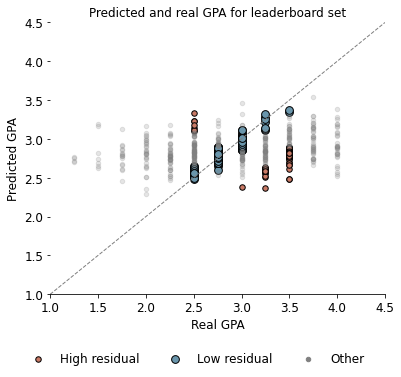

In [1228]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
fontsize=12
for k, g in grouped:
    if k == 'Low residual': g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', linewidth=1, s=60, edgecolor='black', color=colorcode[k], label=k)
    elif k == 'High residual': g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', color=colorcode[k], s=30, linewidth=1, edgecolor='black', label=k)
    else: g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', alpha=0.2, color=colorcode[k], label=k)

#ax.scatter(y_true, y_pred_true)
ax.set_xlim((1, 4.5))
ax.set_ylim((1,4.5))
ax.set_xlabel("Real GPA", fontsize=fontsize)
ax.set_ylabel("Predicted GPA", fontsize=fontsize)

# Set font sizes
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
ax.plot(x,y, linewidth=1, color='grey', linestyle='--')

for sp in ['right', 'top', 'left']: 
    ax.spines[sp].set_visible(False)
    
ax.set_title("Predicted and real GPA for leaderboard set")

leg = ax.legend(frameon=False, ncol=3, bbox_to_anchor=(.97, -0.3), loc='lower right', fontsize=fontsize)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [1229]:
def plot_resid_lines(ax, fontsize, loc='center'):

    for k, g in grouped:
        if k == 'Low residual': g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', linewidth=1, s=40, edgecolor='black', color=colorcode[k], label=k)
        elif k == 'High residual': g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', color=colorcode[k], s=40, linewidth=1, edgecolor='black', label=k)
        else: g.plot(ax=ax, kind='scatter', x='y_true', y='y_pred', alpha=0.2, color=colorcode[k], label=k)

    #ax.scatter(y_true, y_pred_true)
    ax.set_xlim((1, 4.5))
    ax.set_ylim((1,4.5))
    ax.set_xlabel("Real GPA", fontsize=fontsize)
    ax.set_ylabel("Predicted GPA", fontsize=fontsize)

    # Set font sizes
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
    ax.plot(x,y, linewidth=1, color='grey', linestyle='--')

    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)

    ax.set_title("Predicted and real GPA for leaderboard set", fontsize=fontsize, loc=loc)

    leg = ax.legend(frameon=False, ncol=3, bbox_to_anchor=(.97, -0.3), loc='lower right', fontsize=fontsize)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

## 8.3. Calculating z-scores

1. Get the most important features of Lasso
2. Get the feature value of each observation
3. Calculate the standard deviation and mean of each feature (train set)
4. Calculate the z-score for all observations
5. Rank them

In [952]:
len(X_train.columns)

21225

In [950]:
len(model.coef_)

21225

In [954]:
feature_vals = {k:v for k,v in zip(X_train.columns, model.coef_)}

In [956]:
feature_vals = {k: v for k, v in sorted(feature_vals.items(), key=lambda item: item[1])}

In [969]:
features_to_use = list(feature_vals.keys())[:25]

In [1141]:
means = X_train[features_to_use].mean()
std = X_train[features_to_use].std()

In [1142]:
z_scores_df = abs((X_test[features_to_use] - means) / std)

1. Get the indidces that have high and low residuals
2. Calculate the mean z-scores for them by feature

In [1143]:
# Filtering by iloc since the indices are not challenge IDs
high_resids = df_preds[df_preds.category_residual == 'High residual'].index
low_resids = df_preds[df_preds.category_residual == 'Low residual'].index

In [1144]:
high_resids_z = z_scores_df.iloc[high_resids].mean(axis=0)
low_resids_z = z_scores_df.iloc[low_resids].mean(axis=0)

In [1145]:
ftrs_z = pd.DataFrame([high_resids_z, low_resids_z]).transpose()

In [1146]:
ftrs_z.columns = ['High residuals', 'Low residuals']

In [1147]:
ftrs_z = ftrs_z.reset_index()

In [1148]:
ftrs_z['Importance'] = np.arange(0, len(ftrs_z), 1) + 1

In [1149]:

 
# Create a dataframe
value1=np.random.uniform(size=20)
value2=value1+np.random.uniform(size=20)/4
df = pd.DataFrame({'group':list(map(chr, range(65, 85))), 'value1':value1 , 'value2':value2 })
 

In [1150]:
my_range=range(1,len(ftrs_z.index)+1)

In [1151]:
ftrs_z.head()

,index,High residuals,Low residuals,Importance
0,f1b20_2.0,1.032445,0.821900,1
1,m3l4a_nan,0.925578,0.921188,2
2,p5q3bw_log,0.857997,0.682828,3
3,k5g2h,0.929840,0.655235,4
4,p3m21,0.722835,0.779262,5


In [1152]:
v1 = 'Low residuals'
v2 = 'High residuals'

In [1153]:
ftrs_z['Name'] = ftrs_z.apply(lambda x:  str(x['Importance']) + '. ' + str(x['index']), axis=1)

## 8.4. Plotting

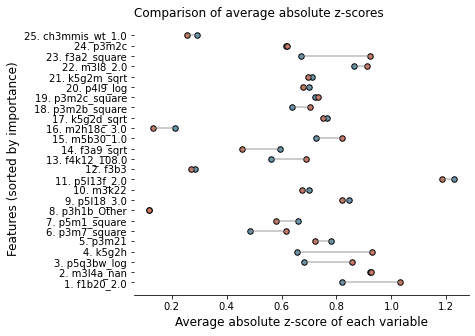

In [1203]:
fontsize=12
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.hlines(y=my_range, xmin=ftrs_z[v1], linewidth=2, xmax=ftrs_z[v2], color='grey', alpha=0.4)
ax.scatter(ftrs_z[v1], my_range, s=30, edgecolor='black', linewidth=1, color=c1, alpha=1, label=v1)
ax.scatter(ftrs_z[v2], my_range, s=30, edgecolor='black', linewidth=1, color=c4, alpha=1, label=v2)

#plt.yticks(my_range, ftrs_z['index'])
ax.set_yticks(ftrs_z['Importance'])
ax.set_yticklabels(ftrs_z['Name'])
ax.set_title("Comparison of average absolute z-scores", loc='left', fontsize=fontsize)
ax.set_xlabel('Average absolute z-score of each variable', fontsize=fontsize)
ax.set_ylabel('Features (sorted by importance)', fontsize=fontsize)

for sp in ['right', 'top', 'left']: 
    ax.spines[sp].set_visible(False)
    

plt.show()

In [1230]:
def plot_lollipop(ax, fontsize=14, loc='center'):

    ax.hlines(y=my_range, xmin=ftrs_z[v1], linewidth=3, xmax=ftrs_z[v2], color='grey', alpha=0.4)
    ax.scatter(ftrs_z[v1], my_range, s=60, edgecolor='black', linewidth=2, color=c1, alpha=1, label=v1)
    ax.scatter(ftrs_z[v2], my_range, s=60, edgecolor='black', linewidth=2, color=c4, alpha=1, label=v2)

    #plt.yticks(my_range, ftrs_z['index'])
    ax.set_yticks(ftrs_z['Importance'])
    ax.set_yticklabels(ftrs_z['Name'])
    ax.set_title("Comparison of absolute average z-scores", loc=loc, fontsize=fontsize)
    ax.set_xlabel('Average absolute z-score of each variable', fontsize=fontsize)
    ax.set_ylabel('Features (sorted by importance)', fontsize=fontsize)
    
    # Set tick axes sizes
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
    
    for sp in ['right', 'top', 'left']: 
        ax.spines[sp].set_visible(False)
    leg = ax.legend(frameon=False, ncol=2, bbox_to_anchor=(.85, -0.3), loc='lower right', fontsize=fontsize)


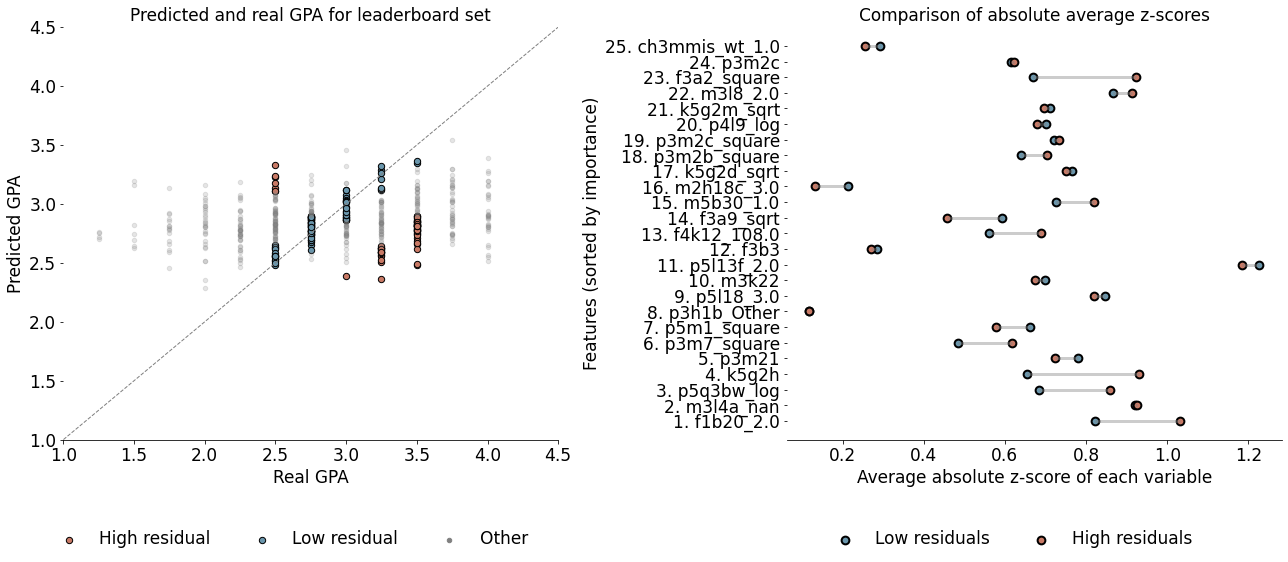

In [1232]:
fig, axs = plt.subplots(1,2, figsize=(18,8))

plot_resid_lines(axs[0], fontsize=17, loc='center')
plot_lollipop(axs[1], fontsize=17, loc='center')
plt.tight_layout()
fig.savefig('resid_comparison_zscores.png')

# 9. Other

## 9.1. Calculating the statistic that each variable comes from some distribution

In [1143]:
from scipy.stats import anderson

In [1167]:
dist_types = ['norm', 'expon', 'logistic', 'gumbel_l', 'gumbel_r', 'uniform']

In [1190]:
mdata = pd.read_json('variable_metadata.json')

In [1193]:
mdata = mdata.transpose()

In [1197]:
conts = mdata[mdata.data_type=='Continuous'].index.tolist()

In [1205]:
conts2 = [c for c in conts if c in X_train.columns]

<AxesSubplot:>

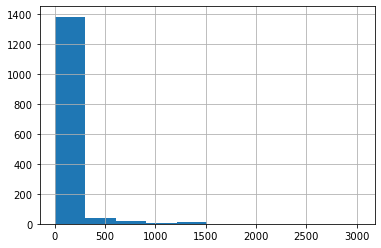

In [1210]:
X_train[conts2]['f1citywt'].hist()

In [1212]:
results_dist = {}
for dtype in dist_types:
    results_dist[dtype] = []
    for c in conts2:
        arr1 = np.array(X_train[col])
        s, p = kstest(arr1, dtype, alternative='two-sided')
        results_dist[dtype].append(p)

In [1214]:
for k,v in results_dist.items():
    results_dist[k] = np.array(v)

In [1232]:
for k in results_dist.keys():
    print(k, pd.Series(results_dist[k]).value_counts())

norm 0.0    647
dtype: int64
expon 0.0    647
dtype: int64
logistic 0.0    647
dtype: int64
gumbel_l 0.0    647
dtype: int64
gumbel_r 0.0    647
dtype: int64
